In [1]:
%cd ..

/misc/vlgscratch4/LakeGroup/wentao/multimodal-baby


In [2]:
from pathlib import Path
from collections import namedtuple, defaultdict
import itertools
import functools
import math
import numpy as np
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
from torchvision.transforms.functional import resized_crop
from multimodal.multimodal_saycam_data_module import MultiModalSAYCamDataModule
from multimodal.coco_captions_data_module import COCOCaptionsDataModule
from multimodal.multimodal import TextEncoder, MultiModalModel, LanguageModel
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.multimodal_data_module import PAD_TOKEN_ID, UNK_TOKEN_ID, SOS_TOKEN_ID, EOS_TOKEN_ID, normalizer
from multimodal.utils import map_structure
from ngram import NGramModel
from train import _setup_parser
from representation_similarity import *

figsize = (13, 12)
sns.set_theme(
    style='white',
    font='monospace',
    rc={
        'figure.figsize': figsize,
        'axes.grid': False,
        'xtick.bottom': False,
        'xtick.top': False,
        'ytick.left': False,
        'ytick.right': False,
        'axes.spines.left': False,
        'axes.spines.bottom': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

np.set_printoptions(suppress=True, precision=2, linewidth=120)
pd.options.display.width = 120

def get_n_rows(n_items, n_cols):
    return (n_items - 1) // n_cols + 1


pos_mappings = [
    ('pos0', {
        "''": ".",
        ",": ".",
        ".": ".",
        ":": ".",
        "ADD": "UH",
        "CC": "CC",
        "CD": "CD",
        "DT": "DT",
        "EX": "EX",
        "FW": "UH",
        "IN": "IN",
        "JJ": "JJ",
        "JJR": "JJR",
        "JJS": "JJS",
        "LS": ".",
        "MD": "MD",
        "NFP": "UH",
        "NN": "NN",
        "NNP": "NNP",
        "NNPS": "NNS",
        "NNS": "NNS",
        "PDT": "PDT",
        "POS": "POS",
        "PRP": "PRP",
        "PRP$": "PRP$",
        "RB": "RB",
        "RBR": "RBR",
        "RBS": "RBS",
        "RP": "RP",
        "SYM": ".",
        "TO": "TO",
        "UH": "UH",
        "VB": "VB",
        "VBD": "VBD",
        "VBG": "VBG",
        "VBN": "VBN",
        "VBP": "VBP",
        "VBZ": "VBZ",
        "WDT": "WDT",
        "WP": "WP",
        "WP$": "WP$",
        "WRB": "WRB",
        "``": ".",
    }),
    ('pos1', {
        "''": ".",
        ",": ".",
        ".": ".",
        ":": ".",
        "ADD": "UH",
        "CC": "CC",
        "CD": "CD",
        "DT": "DT",
        "EX": "PRP",
        "FW": "UH",
        "IN": "IN",
        "JJ": "adjective",
        "JJR": "adjective",
        "JJS": "adjective",
        "LS": ".",
        "MD": "MD",
        "NFP": "UH",
        "NN": "noun",
        "NNP": "noun",
        "NNPS": "noun",
        "NNS": "noun",
        "PDT": "DT",
        "POS": "POS",
        "PRP": "PRP",
        "PRP$": "PRP",
        "RB": "adverb",
        "RBR": "adverb",
        "RBS": "adverb",
        "RP": "RP",
        "SYM": ".",
        "TO": "TO",
        "UH": "UH",
        "VB": "verb",
        "VBD": "verb",
        "VBG": "verb",
        "VBN": "verb",
        "VBP": "verb",
        "VBZ": "verb",
        "WDT": "wh-word",
        "WP": "wh-word",
        "WP$": "wh-word",
        "WRB": "wh-word",
        "``": ".",
    }),
    ('pos2', {
        "''": ".",
        ",": ".",
        ".": ".",
        ":": ".",
        "ADD": ".",
        "CC": "function word",
        "CD": "cardinal number",
        "DT": "function word",
        "EX": "function word",
        "FW": ".",
        "IN": "function word",
        "JJ": "adjective",
        "JJR": "adjective",
        "JJS": "adjective",
        "LS": ".",
        "MD": "function word",
        "NFP": ".",
        "NN": "noun",
        "NNP": "noun",
        "NNPS": "noun",
        "NNS": "noun",
        "PDT": "function word",
        "POS": "function word",
        "PRP": "function word",
        "PRP$": "function word",
        "RB": "adverb",
        "RBR": "adverb",
        "RBS": "adverb",
        "RP": "function word",
        "SYM": ".",
        "TO": "function word",
        "UH": ".",
        "VB": "verb",
        "VBD": "verb",
        "VBG": "verb",
        "VBN": "verb",
        "VBP": "verb",
        "VBZ": "verb",
        "WDT": "function word",
        "WP": "function word",
        "WP$": "function word",
        "WRB": "function word",
        "``": ".",
    }),
]

pos_palette = {
    "''": "black",
    "``": "black",
    ",": "black",
    ".": "black",
    ":": "black",
    ".": "black",
    "LS": "black",
    "SYM": "black",
    "CC": "brown",
    "cardinal number": "tab:gray",
    "CD": "tab:gray",
    "DT": "salmon",
    "EX": "rosybrown",
    "function word": "tab:purple",
    "IN": "tab:purple",
    "adjective": "tab:orange",
    "JJ": "tab:orange",
    "JJR": "gold",
    "JJS": "yellow",
    "MD": "rosybrown",
    "noun": "tab:blue",
    "NN": "tab:blue",
    "NNP": "navy",
    "NNS": "cadetblue",
    "PDT": "saddlebrown",
    "POS": "grey",
    "PRP": "tab:olive",
    "PRP$": "olivedrab",
    "adverb": "tab:pink",
    "RB": "tab:pink",
    "RBR": "magenta",
    "RBS": "palevioletred",
    "RP": "darkviolet",
    "TO": "indigo",
    "ADD": "tab:green",
    "FW": "tab:green",
    "NFP": "tab:green",
    "UH": "tab:green",
    "verb": "tab:red",
    "VB": "tab:red",
    "VBD": "salmon",
    "VBG": "orangered",
    "VBN": "chocolate",
    "VBP": "pink",
    "VBZ": "crimson",
    "WDT": "darkcyan",
    "WP": "slateblue",
    "WP$": "darkslateblue",
    "wh-word": "tab:cyan",
    "WRB": "tab:cyan",
}

/usr/local/stow/python-3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
class SumData(namedtuple('SumDataTuple', ['cnt', 'loss', 'vector', 'embedding'])):
    """data structure to aggregate count, loss, vector, embedding
    """
    @property
    def mean_vector(self):
        return self.vector / np.expand_dims(self.cnt, -1)

    @property
    def mean_loss(self):
        return self.loss / self.cnt

    @property
    def ppl(self):
        return min(math.exp(self.mean_loss), 99999.99)

    def __add__(self, b):
        return SumData(
            cnt = self.cnt + b.cnt,
            loss = self.loss + b.loss,
            vector = self.vector + b.vector,
            embedding = self.embedding,
        )

    def __sub__(self, b):
        return SumData(
            cnt = self.cnt - b.cnt,
            loss = self.loss - b.loss,
            vector = self.vector - b.vector,
            embedding = self.embedding,
        )

    def to_numpy(self):
        return SumData(
            cnt = self.cnt,
            loss = self.loss,
            vector = self.vector.cpu().numpy(),
            embedding = self.embedding.cpu().numpy() if self.embedding else self.embedding
        )

def zero_sum_data(hidden_dim, shape=()):
    return SumData(
        cnt = np.zeros(shape, dtype=int),
        loss = np.zeros(shape),
        vector = np.zeros(shape + (hidden_dim,)),
        embedding = None,
    )

def zero_sum_data_like(sum_data):
    return zero_sum_data(sum_data.vector.shape[-1], shape=sum_data.cnt.shape)


token_field = 'token'


class Key(namedtuple('Key', ['token_id', 'pos'])):
    """
    token_id: token index
    pos: pos tag
    """


def row_prefix_str(row, with_cnt=False):
    prefix = f"{row[token_field]:<10} {row['pos']:<4}" if not pd.isna(row['pos']) else f"{row[token_field]:<15}"
    if with_cnt:
        prefix = prefix + f" {row['cnt']:>6}"
    return prefix


def row_str(row):
    return row_prefix_str(row, with_cnt=True) + ': ' + ' '.join(f"{row[name].ppl:9.3f}" for name in names)

In [4]:
# concreteness/other measures related


# modified from https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
from nltk.corpus import wordnet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('JJ'):
        return wordnet.ADJ
    elif treebank_tag.startswith('VB'):
        return wordnet.VERB
    elif treebank_tag.startswith('NN'):
        return wordnet.NOUN
    elif treebank_tag.startswith('RB'):
        return wordnet.ADV
    else:
        return ''

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(word, pos):
    wordnet_pos = get_wordnet_pos(pos)
    if not wordnet_pos:
        wordnet_pos = wordnet.NOUN  # default
    return lemmatizer.lemmatize(word, pos=wordnet_pos)


class WordRatings:
    """Maintaining ratings of words."""
    def __init__(self, excel_path, word_field='Word', **kwargs):
        """Read data from excel_path."""
        self.data = pd.read_excel(excel_path, **kwargs)
        self.data.info()
        self.word_field = word_field

        self.word2index = {
            row[self.word_field].lower(): index
            for index, row in self.data.iterrows() if isinstance(row[self.word_field], str)
        }

    def word_to_index(self, word, pos):
        try:
            return self.word2index[word]
        except KeyError:
            try:
                return self.word2index[lemmatize(word, pos)]
            except KeyError:
                return None

    def extend_items(self, items, word_label):
        mapped_index = items.index.map(lambda key: self.word_to_index(idx2word[key[0]], key[1]))
        available = mapped_index.notna()
        available_index = items.index[available]
        available_mapped_index = mapped_index[available]
        d = self.data.loc[available_mapped_index]
        d.rename(lambda column: word_label if column == self.word_field else column)
        d.index = available_index
        items[d.columns] = d


concreteness_data = WordRatings("/misc/vlgscratch4/LakeGroup/shared_data/Concreteness ratings Brysbaert2014.xlsx")
norm_data = WordRatings("/misc/vlgscratch4/LakeGroup/shared_data/VanArsdall_Blunt_NormData.xlsx", sheet_name=1)

conc_field = 'Conc.M'


def extend_point_items(items, name, attr, n=None):
    if n is None:
        n = {'tsne': 2, 'eigen': 5}[attr]
    for idx in range(n):
        items[f'{name} {attr} {idx}'] = items[name].map(lambda value: getattr(value, attr + '_point')[idx])


def extend_items(items):
    for pos_field, pos_mapping in pos_mappings:
        items[pos_field] = items['pos'].map(pos_mapping).astype('category')
    items['logcnt'] = np.log(items['cnt'])

    for n, name in enumerate(names):
        items[f'{name} loss'] = items[name].map(lambda value: value.mean_loss)
        if n != 0:
            items[f'{name} loss diff'] = items[f'{name} loss'] - items[f'{names[0]} loss']
        try:
            extend_point_items(items, name, 'tsne')
        except AttributeError:
            pass
        try:
            extend_point_items(items, name, 'eigen')
        except AttributeError:
            pass

    concreteness_data.extend_items(items, 'conc Word')
    norm_data.extend_items(items, 'norm Word')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39954 entries, 0 to 39953
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Word           39953 non-null  object 
 1   Bigram         39954 non-null  int64  
 2   Conc.M         39954 non-null  float64
 3   Conc.SD        39954 non-null  float64
 4   Unknown        39954 non-null  int64  
 5   Total          39954 non-null  int64  
 6   Percent_known  39954 non-null  float64
 7   SUBTLEX        39954 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Word          1200 non-null   object 
 1   Category      1200 non-null   object 
 2   Living        1200 non-null   int64  
 3   Thought       1200 non-null   int64  
 4   Repro         1200 n

In [5]:
# plotting utilities

def split_tokens(inp):
    tokens = inp.split()
    token_ids = []
    for token in tokens:
        token_id = word2idx.get(token, UNK_TOKEN_ID)
        if token_id == UNK_TOKEN_ID:
            print(f'mapping {token} to UNK')
        token_ids.append(token_id)
    return token_ids


def get_vectors_from_values(values, vector_attr='mean_vector'):
    return np.array([getattr(value, vector_attr) for value in values])


def get_all_vectors_from_items(items, vector_attr='mean_vector'):
    return (get_vectors_from_values(items[name], vector_attr=vector_attr) for name in names)


def plot_repres_sim_heatmap(vectors, title=None, ax=None):
    dissim_matrices = [cosine_dissim_matrix(V) for V in vectors]

    repres_sim_matrix = np.array([[rsa_of_dissim_matrices(A, B) for B in dissim_matrices] for A in dissim_matrices])
    plot_sim_heatmap(repres_sim_matrix, names, annot=True, size=1., title=title, ax=ax)


def plot_dendrogram(items, vector_attr='mean_vector', heatmap=False, annot=False, size=0.7, cluster_by_first=False, pos_field='pos0', title=None):
    """linkage clustering and dendrogram plotting
    items: pd.DataFrame
    vector_attr: use value.vector_attr; default: 'mean_vector'; can be 'embedding'
    heatmap: bool, plot something like plot_sim_heatmap
    """
    from scipy.cluster.hierarchy import dendrogram, linkage

    n_items = len(items)
    vectors = list(get_all_vectors_from_items(items, vector_attr=vector_attr))

    plot_repres_sim_heatmap(vectors, title=title)
    plt.show()

    # build color map
    colors = items[pos_field].astype('O').map(pos_palette).tolist()

    for n, (name, V) in enumerate(zip(names, vectors)):
        print(f'{name}:')
        Z = linkage(V, method='average', metric='cosine')  # of shape (number of merges = n_items - 1, 4)

        def llf(index):
            if index < n_items:
                row = items.iloc[index]
                ppl = row[name].ppl
                base_ppl = 0. if n == 0 else row[names[0]].ppl
                return row_prefix_str(row, with_cnt=True) + ' ' + f'{ppl-base_ppl:+9.2f}={ppl:8.2f}'
            else:
                merge_index = index - n_items
                return f'{merge_index} {int(Z[merge_index, 3])} {Z[merge_index, 2]:.3f}'

        p = 10000

        plt.figure(figsize=(25 / 2, 0.3 * min(p, n_items))) # 0.1
        dendrogram(
            Z,
            truncate_mode='lastp',
            p=p,
            orientation='left',
            leaf_rotation=0.,
            leaf_font_size=16.,
            leaf_label_func=llf,
        )

        if title is not None:
            plt.title(f"{name} {title}")

        if heatmap:
            if not cluster_by_first or n == 0:
                Z_heatmap = Z

            prefix_labels = [row_prefix_str(row) for _, row in items.iterrows()]
            llf_labels = list(map(llf, range(n_items)))

            matrix = cosine_matrix(V)

            off_diag = ~np.eye(matrix.shape[0], matrix.shape[1], dtype=bool)
            v = np.max(np.abs(matrix[off_diag]))
            vmin = -v
            vmax = +v

            g = sns.clustermap(
                matrix,
                row_linkage=Z_heatmap,
                col_linkage=Z_heatmap,
                figsize=(22, 20),
                cbar_pos=None,
                # kwargs for heatmap
                vmin=vmin, vmax=vmax, center=0,
                annot=annot, fmt='.2f',
                xticklabels=prefix_labels,
                yticklabels=prefix_labels,
                row_colors=colors,
                col_colors=colors,
                square=True,
                #cbar=False,
                dendrogram_ratio=0., # remove all dendrograms
                colors_ratio=0.02,
            )
            g.ax_col_dendrogram.remove()

            if title is not None:
                plt.title(f"{name} {title}")

        plt.show()


def get_tsne_points_from_vectors(
        vectors,
        n_components=2,
        random_state=0,
        perplexity=50,
        learning_rate='auto',
        n_iter=1000,
        metric='cosine',
        **kwargs,
    ):
    from sklearn.manifold import TSNE

    tsne = TSNE(
        n_components=n_components,
        random_state=random_state,
        perplexity=perplexity,
        learning_rate=learning_rate,
        n_iter=n_iter,
        metric=metric,
        **kwargs,
    )
    points = tsne.fit_transform(vectors)
    print('T-SNE done.')
    return points

def get_eigen_points_from_vectors(vectors, print_singular_values=False, **kwargs):
    from scipy.linalg import svd

    U, s, Vh = svd(vectors, full_matrices=False, **kwargs)
    print('SVD done.')
    if print_singular_values:
        print('singular values:')
        print(s)
    return U

def convert_attr_for_each(objs, get_attr='mean_vector', set_attr='tsne_point', converter=get_tsne_points_from_vectors, **kwargs):
    attrs = np.array([getattr(obj, get_attr) for obj in objs])

    new_attrs = converter(attrs, **kwargs)

    for obj, new_attr in zip(objs, new_attrs):
        setattr(obj, set_attr, new_attr)

get_tsne_points = functools.partial(convert_attr_for_each, set_attr='tsne_point', converter=get_tsne_points_from_vectors)
get_eigen_points = functools.partial(convert_attr_for_each, set_attr='eigen_point', converter=get_eigen_points_from_vectors)


plotting_variable_keys = {'x', 'y', 'hue', 'size', 'style'}

def plot(fn, items, n_items=None, xrange=None, yrange=None, token_kwargs=None, palette=None, title=None, suptitle=None, hlines=None, vlines=None, figsize=figsize, **kwargs):
    """plot items using fn
    fn: seaborn plot function
    items: pd.DataFrame items; will drop items with missing values in the variables
    n_items: plot at most n_items items
    xrange, yrange: plot points only within this range
    token_kwargs: kwargs to plt.text to add token text labels; if None, do not add text labels
    palette: palette for hue; if None, for pos it will use pos_palette; for other categories, use 'tab20'
    kwargs: all other kwargs to pass to fn
    """

    if hlines is None:
        hlines = []
    if vlines is None:
        vlines = []

    variable_keys = plotting_variable_keys & kwargs.keys()
    variable_keys = {key for key in variable_keys if kwargs[key] is not None}

    if palette is None and 'hue' in variable_keys:
        hue = kwargs['hue']
        if 'pos' in hue:
            palette = pos_palette
        elif items.dtypes[hue] == "category":
            palette = 'tab20'
    if fn not in [sns.regplot]:
        kwargs['palette'] = palette

    data = items.dropna(subset=[kwargs[key] for key in variable_keys])
    if xrange is not None:
        x = kwargs['x']
        data = data[data[x].map(lambda x: xrange[0] <= x <= xrange[1])]
    if yrange is not None:
        y = kwargs['y']
        data = data[data[y].map(lambda y: yrange[0] <= y <= yrange[1])]
    if n_items is not None:
        data = data.iloc[:n_items]
    print(f'plotting {len(data)}/{len(items)} = {len(data) / len(items):.2%} items...')
    ret = fn(data=data, **kwargs)

    if token_kwargs is not None and 'x' in variable_keys and 'y' in variable_keys:
        x = kwargs['x']
        y = kwargs['y']
        for _, row in data.iterrows():
            plt.text(row[x], row[y], row[token_field], **token_kwargs)

    if isinstance(ret, sns.FacetGrid):
        ret.figure.set_size_inches(*figsize)
        all_ax = itertools.chain.from_iterable(ret.axes)
    else:
        all_ax = [ret]

    for ax in all_ax:
        for hline in hlines:
            ax.axhline(hline)
        for vline in vlines:
            ax.axvline(vline)

    if title is not None:
        if title == "vs":
            title = f"{kwargs['x']} vs {kwargs['y']}"
        plt.title(title)
    if suptitle is not None:
        plt.suptitle(suptitle)

    plt.show()
    return ret


def plot_sim_heatmap(matrix, labels, annot=True, size=0.7, title=None, ax=None):
    designated_ax = ax is not None
    ax = sns.heatmap(matrix, vmin=-1, vmax=1, center=0, annot=annot, fmt='.2f', xticklabels=labels, yticklabels=labels, square=True, cbar=False, ax=ax)
    if not designated_ax:
        ax.figure.set_size_inches(size * (matrix.shape[0] + 2.), size * (matrix.shape[1] + 2.))
    if title is not None:
        ax.set_title(title)


def plot_loss_heatmap(names, losses, y_labels, annot=True, size=0.7, plot_diff=True, plot_ori=False):
    data = [losses[0]]
    yticklabels = [names[0]]
    for i in range(1, len(losses)):
        losses_i = losses[i]
        if plot_diff:
            data.append([loss_i - loss_0 for loss_0, loss_i in zip(losses[0], losses_i)])
            yticklabels.append(f'{names[i]} - {names[0]}')
        if plot_ori:
            data.append(losses_i)
            yticklabels.append(f'{names[i]}')
    ax = sns.heatmap(data, center=0, annot=annot, fmt='.2f', xticklabels=y_labels, yticklabels=yticklabels, square=False, cbar=False)
    ax.figure.set_size_inches(size * (len(data[0]) + 1.), size * 0.5 * (len(data) + .5))
    plt.show()


def plot_vector_sim_heatmap(items, diff=False, vector_attr='mean_vector', one_figure=False, size=0.7, **kwargs):
    if diff:
        if len(items) % 2 != 0:
            print('Error: number of items should be even.')
            return

    tokens = items[token_field]
    if diff:
        labels = [f'{tokens.iloc[i]}-{tokens.iloc[i+1]}' for i in range(0, len(tokens), 2)]
    vectors = list(get_all_vectors_from_items(items, vector_attr=vector_attr))

    if one_figure:
        n_cols = 3
        n_rows = get_n_rows((0 if diff else 1) + len(vectors), n_cols)
        s = size * (len(items) + 2.)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(s * n_cols, s * n_rows), squeeze=False)
        all_axes = itertools.chain.from_iterable(axes)

    if not diff:
        plot_repres_sim_heatmap(vectors, ax=next(all_axes) if one_figure else None)
        if not one_figure:
            plt.show()

    for V, name in zip(vectors, names):
        if diff:
            V = V.reshape((V.shape[0] // 2, 2,) + V.shape[1:])
            V = V[:, 1] - V[:, 0]
        plot_sim_heatmap(cosine_matrix(V), labels if diff else tokens, size=size, title=name, ax=next(all_axes) if one_figure else None, **kwargs)
        if not one_figure:
            plt.show()

    if one_figure:
        for ax in all_axes:
            ax.axis("off")
        plt.show()

In [6]:
from multimodal.attention_maps import Hook, gradCAM_with_act_and_grad, n_inv, plot_image


def torch_to_numpy_image(img):
    return img.permute(1, 2, 0).cpu().numpy()


def gradCAM_for_captioning_lm(model, x, y, y_len, steps=None):
    if steps is None:
        steps = list(range(y_len.item()))

    model.language_model.text_encoder.lstm.train()

    layer = model.vision_encoder.model.layer4

    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    # Attach a hook to the model at the desired layer.
    with Hook(layer) as hook:
        # Do a forward and backward pass.
        loss, outputs, logits, attns, labels = model.calculate_ce_loss(
            y.unsqueeze(0).to(device), y_len.unsqueeze(0).to(device), x=x.unsqueeze(0).to(device),
            tokenwise=True)

        gradcams = []
        for step in steps:
            if step == 0:
                gradcam = None
            else:
                hook.data.grad = None
                loss[0, step - 1].backward(retain_graph=True)
                gradcam = gradCAM_with_act_and_grad(hook.activation, -hook.gradient)
                gradcam = gradcam.squeeze().detach().cpu().numpy()
            gradcams.append(gradcam)

    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    model.language_model.text_encoder.lstm.eval()

    return gradcams


def attention_for_attention_lm(model, x, y, y_len, steps=None):
    if steps == list(range(y_len.item())):
        steps = None

    loss, outputs, logits, attns, labels = model.calculate_ce_loss(
        y.unsqueeze(0).to(device), y_len.unsqueeze(0).to(device), x=x.unsqueeze(0).to(device))

    ret = attns[0].detach().cpu().numpy()
    return ret if steps is None else ret[steps]

In [7]:
# get counts, vectors, losses, pos tags

from tqdm import tqdm


def build_ngram_model(N, vocab_size, train_dataloader):
    ngram_model = NGramModel(N, vocab_size)

    for x, y, y_len, raw_y in tqdm(train_dataloader):
        y, y_len = y.to(device=device), y_len.to(device=device)
        ngram_model.update(y, y_len)

    return ngram_model


import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos', tokenize_pretokenized=True)

pos_tags = {}

def get_pos_tags(dataloader, dataset_name, split):
    cache_path = Path('dataset_cache') / dataset_name / f'{split}.pos.cache'
    cache_path.parent.mkdir(parents=True, exist_ok=True)
    if cache_path.exists():
        print(f'load cached pos tags: {cache_path}')
        return torch.load(cache_path)

    pos_tags = []

    for x, y, y_len, raw_y in tqdm(dataloader):
        batch_size = y.size(0)
        utterance_idxes_list = [utterance[:length].tolist() for utterance, length in zip(y, y_len)]

        tagging_indices_batch, tagging_words_batch = [], []

        for i in range(batch_size):
            utterance_idxes = utterance_idxes_list[i]
            utterance_words = [idx2word[idx] for idx in utterance_idxes]
            tagging_indices, tagging_words = zip(*[(index, word) for index, word in enumerate(utterance_words) if utterance_idxes[index] not in [SOS_TOKEN_ID, EOS_TOKEN_ID] and word])
            tagging_indices_batch.append(tagging_indices)
            tagging_words_batch.append(tagging_words)

        doc = nlp(tagging_words_batch)

        for i in range(batch_size):
            utterance_idxes = utterance_idxes_list[i]
            tagging_indices = tagging_indices_batch[i]
            sentence = doc.sentences[i]
            utterance_pos_tags = ['.'] * len(utterance_idxes)
            for index, token in zip(tagging_indices, sentence.tokens):
                utterance_pos_tags[index] = token.words[0].xpos

            pos_tags.append(utterance_pos_tags)

    torch.save(pos_tags, cache_path)

    return pos_tags


def get_outputs_and_loss(model, x, y, y_len, single_example=False):
    is_NGramModel = isinstance(model, NGramModel)
    hidden_dim = 0 if is_NGramModel else model.language_model.text_encoder.hidden_dim

    batch = x, y, y_len
    if single_example:
        batch = map_structure(lambda t: t.unsqueeze(0), batch)
    batch = map_structure(lambda t: t.to(device=device), batch)
    x, y, y_len = batch

    if is_NGramModel:
        loss = model.calculate_ce_loss(y, y_len, tokenwise=True)
        outputs = torch.zeros(*(y.shape + (hidden_dim,)), dtype=torch.float, device=device)
    else:
        loss, outputs, logits, attns, labels = model.calculate_ce_loss(y, y_len, x=x, tokenwise=True)
    if is_NGramModel or model.language_model.text_encoder.regressional: # loss, logits, labels is shifted
        # pad loss with preceeding 0
        loss = F.pad(loss, (1, 0))

    if single_example:
        outputs, loss = map_structure(lambda t: t.squeeze(0), (outputs, loss))

    return outputs, loss


def get_losses_and_token_pos_items(model, dataloader, pos_tags):
    is_NGramModel = isinstance(model, NGramModel)
    hidden_dim = 0 if is_NGramModel else model.language_model.text_encoder.hidden_dim

    def torch_zero_sum_data():
        return SumData(
            cnt = np.array(0),
            loss = np.array(0.),
            vector = torch.zeros(hidden_dim, device=device),
            embedding = None,
        )

    losses = []
    items = defaultdict(torch_zero_sum_data)

    with torch.no_grad():
        i_example = 0
        for x, y, y_len, raw_y in tqdm(dataloader):
            batch_size = y.size(0)
            utterance_idxes_list = [utterance[:length].tolist() for utterance, length in zip(y, y_len)]

            outputs, loss = get_outputs_and_loss(model, x, y, y_len)

            for i in range(batch_size):
                utterance_idxes = utterance_idxes_list[i]
                utterance_pos_tags = pos_tags[i_example + i]
                losses.append(loss[i, :len(utterance_idxes)].cpu().numpy())
                for j in range(len(utterance_idxes)):
                    idx = utterance_idxes[j]
                    pos_tag = utterance_pos_tags[j]
                    items[Key(idx, pos_tag)] += SumData(1, loss[i, j].item(), outputs[i, j].detach(), None)

            i_example += batch_size

    items = {key: value.to_numpy() for key, value in items.items()}

    return losses, items


def get_token_items(token_pos_items):
    token_pos_items = list(token_pos_items.items())
    token_pos_items.sort()

    token_items = {}

    i, j = 0, 0
    while i < len(token_pos_items):
        token_id = token_pos_items[i][0].token_id

        while j < len(token_pos_items) and token_pos_items[j][0].token_id == token_id:
            j += 1

        items = token_pos_items[i : j]

        # set the POS tag of a word as the most frequent POS tag; if there're multiple most frequent POS tags, select the smallest POS tag string
        key = max(items, key=lambda item: (item[1].cnt.item(), item[0].pos))[0]
        # aggregate values
        token_items[key] = sum([item[1] for item in items], start=zero_sum_data_like(items[0][1]))

        i = j

    return token_items


ModelItems = namedtuple('ModelItems', ['losses', 'token_pos_items', 'token_items'])


def build_series(items):
    s = pd.Series(items)
    s.index.set_names(Key._fields, inplace=True)
    s.sort_index(inplace=True)
    return s


def get_model_items(model, checkpoint_path, dataloader, split):
    cache_path = Path(checkpoint_path + f'.{split}.cache')
    if cache_path.exists():
        # load from cache
        print(f'load cached model items {cache_path}')
        model_items = torch.load(cache_path)

    else:
        losses, token_pos_items = get_losses_and_token_pos_items(model, dataloader, pos_tags[split])
        token_items = get_token_items(token_pos_items)

        embeddings = model.text_encoder.embedding.weight.detach().cpu().numpy()
        new_token_items = {}
        for key in token_items:
            value = token_items[key]
            value = SumData(cnt=value.cnt, loss=value.loss, vector=value.vector, embedding=embeddings[key.token_id])
            new_token_items[key] = value
        token_items = new_token_items

        model_items = ModelItems(losses, token_pos_items, token_items)
        torch.save(model_items, cache_path)

    model_items = ModelItems(model_items.losses, build_series(model_items.token_pos_items), build_series(model_items.token_items))
    return model_items


def stack_items(items_list):
    data = pd.DataFrame(dict(zip(names, items_list)), columns=names)
    data.reset_index(inplace=True)
    data[token_field] = data['token_id'].map(idx2word)
    data['pos'] = data['pos'].astype('category')
    data['cnt'] = data[names[0]].map(lambda value: value.cnt)
    data.set_index(list(Key._fields), drop=False, inplace=True)
    return data

2022-05-08 23:20:01 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2022-05-08 23:20:02 INFO: Use device: gpu
2022-05-08 23:20:02 INFO: Loading: tokenize
2022-05-08 23:20:02 INFO: Loading: pos
2022-05-08 23:20:05 INFO: Done loading processors!


In [8]:
# load model from checkpoint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# select from list of checkpoints
all_checkpoint_paths = {
    "saycam": (
        ("lm", "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=47.ckpt"),
        #("lm1", "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_1/epoch=43.ckpt"),
        #("lm2", "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_2/epoch=27.ckpt"),
        #("lm3", "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_3/epoch=31.ckpt"),
        ("capt", "checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=72.ckpt"),
#        ("capt_ft", "checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0_finetune_cnn/last.ckpt"),
        #("attn", "checkpoints/lm_dataset_saycam_captioning_False_attention_True_text_encoder_lstm_embedding_dim_512_batch_size_8_lr_0.001_lr_scheduler_True_patience_10_weight_decay_0.05_eval_include_sos_eos_True_seed_0/epoch=48.ckpt"),
        #("capt_attn", "checkpoints/lm_dataset_saycam_captioning_True_attention_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.5_batch_size_8_lr_0.001_lr_scheduler_True_patience_10_weight_decay_0.05_eval_include_sos_eos_True_seed_0/epoch=65.ckpt"),
        #("capt_attn_gt", "checkpoints/lm_dataset_saycam_captioning_True_attention_True_attention_gate_True_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_patience_10_weight_decay_0.05_eval_include_sos_eos_True_seed_0/epoch=67.ckpt"),
        ("capt_attn_gt_reg", "checkpoints/lm_dataset_saycam_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_embedding_dim_512_tie_True_bias_True_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_patience_10_weight_decay_0.05_seed_0/epoch=42.ckpt"),
#        ("capt_attn_gt_reg_ft", "checkpoints/lm_dataset_saycam_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_embedding_dim_512_tie_True_bias_True_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_patience_10_weight_decay_0.05_seed_0_finetune_cnn/last.ckpt"),

        ("cbow", "checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.0001_lr_scheduler_True_patience_2_weight_decay_0.03_seed_0/epoch=199.ckpt"),

        #("contrastive_bs8", "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.05_val_batch_size_16_seed_0/epoch=199.ckpt"),
        #("contrastive_bs512", "checkpoints/multimodal_dataset_saycam_captioning_False_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_512_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/last.ckpt"),
        ("contrastive", "checkpoints/multimodal_dataset_saycam_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_fix_temperature_True_temperature_0.07_batch_size_512_lr_0.003_lr_scheduler_True_weight_decay_0.05_eval_include_sos_eos_False_seed_0/epoch=45.ckpt"),

        ("joint_bs8", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_8_optimizer_AdamW_lr_0.003_lr_scheduler_True_weight_decay_0.05_val_batch_size_16_eval_include_sos_eos_False_seed_0/epoch=63.ckpt"),
        #("joint_bs512", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_512_optimizer_AdamW_lr_0.03_lr_scheduler_True_weight_decay_0.05_val_batch_size_16_eval_include_sos_eos_False_seed_0/epoch=140.ckpt"),

        #("ngram", "ngram"),
    ),
    "coco": (
        ("lm", "checkpoints/lm_dataset_coco_captioning_False_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=109.ckpt"),
        #("lm_bs512", "checkpoints/lm_dataset_coco_captioning_False_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_512_lr_0.01_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=67.ckpt"),
#        ("capt", "checkpoints/lm_dataset_coco_captioning_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=149.ckpt"),
        ("capt_ft", "checkpoints/lm_dataset_coco_captioning_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0_finetune_cnn/epoch=210.ckpt"),
        #("capt_bs512", "checkpoints/lm_dataset_coco_captioning_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_512_lr_0.003_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=65.ckpt"),
#        ("capt_attn", "checkpoints/lm_dataset_coco_captioning_True_attention_True_pretrained_cnn_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.0003_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=198.ckpt"),
#        ("capt_attn_gt", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_pretrained_cnn_True_cnn_model_resnext50_32x4d_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=143.ckpt"),
        ("capt_attn_gt_ft", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_pretrained_cnn_True_cnn_model_resnext50_32x4d_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0_finetune_cnn/epoch=198.ckpt"),
        #("capt_attn_gt_reg", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_pretrained_cnn_True_cnn_model_resnext50_32x4d_tie_True_bias_True_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=149.ckpt"),
        ("capt_attn_gt_reg_ft", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_pretrained_cnn_True_cnn_model_resnext50_32x4d_tie_True_bias_True_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0_finetune_cnn/epoch=211.ckpt"),
        #("capt_attn_gt_reg_untie", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_pretrained_cnn_True_cnn_model_resnext50_32x4d_tie_False_bias_True_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=136.ckpt"),
        ("capt_attn_gt_reg_untie_ft", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_pretrained_cnn_True_cnn_model_resnext50_32x4d_tie_False_bias_True_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0_finetune_cnn/epoch=187.ckpt"),

        ("cbow", "checkpoints/lm_dataset_coco_captioning_False_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_2_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.0003_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=153.ckpt"),

        #("contrastive", "checkpoints/multimodal_dataset_coco_captioning_False_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_fix_temperature_True_temperature_0.05_batch_size_512_lr_0.0003_weight_decay_0.01_seed_0/epoch=51.ckpt"),

        #("joint", "checkpoints/joint_dataset_coco_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_fix_temperature_True_temperature_0.05_batch_size_512_lr_0.01_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=191.ckpt"),
    ),
}

names, checkpoint_paths = map(list, zip(*all_checkpoint_paths["saycam"]))

models = []

for checkpoint_n, checkpoint_path in enumerate(checkpoint_paths):
    if checkpoint_path == "ngram":
        ngram_model = build_ngram_model(3, vocab_size, data.train_dataloader())
        models.append(ngram_model)
        continue

    print_dict_args = False
    if print_dict_args:
        ckpt = torch.load(checkpoint)
        print(ckpt['hyper_parameters']['args'])

    print(f"load model from {checkpoint_path}")
    lit_model = MultiModalLitModel.load_from_checkpoint(checkpoint_path, map_location=device)
    #print(lit_model.args)
    lit_model.to(device)

    if checkpoint_n == 0:
        # parse empty args
        parser = _setup_parser()
        args = parser.parse_args("")
        # set args
        for key, value in lit_model.args.items():
            setattr(args, key, value)
        # make the train dataloader deterministic
        args.augment_frames = False
        args.multiple_frames = False
        args.multiple_captions = False
        args.eval_include_sos_eos = True

        # build data module
        dataset_name = args.dataset
        DataModuleClass = {
            "saycam": MultiModalSAYCamDataModule,
            "coco": COCOCaptionsDataModule,
        }[dataset_name]
        data = DataModuleClass(args)
        data.prepare_data()
        data.setup()

        word2idx = lit_model.text_encoder.word2idx
        idx2word = lit_model.text_encoder.idx2word

        vocab = lit_model.text_encoder.vocab
        vocab_size = len(vocab)
        print(f'vocab_size = {vocab_size}')
        # check consistency between vocab and idx2word
        for idx in range(vocab_size):
            assert idx in idx2word

    else:
        assert args.dataset == dataset_name, f"checkpoint {checkpoint_path} ran on a different dataset {args.dataset}"

    lit_model.eval()
    models.append(lit_model)

load model from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=47.ckpt


/home/ww2135/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:73: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


Using base transforms
Calling prepare_data!
SAYCam transcripts have already been downloaded. Skipping this step.
Transcripts have already been renamed. Skipping this step.
Transcripts have already been preprocessed. Skipping this step.
Training frames have already been extracted. Skipping this step.
Training metadata files have already been created. Skipping this step.
Evaluation frames have already been extracted. Skipping this step.
Evaluation metadata files have already been created. Skipping this step.
Extra evaluation metadata files have already been created. Skipping this step.
Vocabulary file already exists. Skipping this step.
Calling setup!
vocab_size = 5589
load model from checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=72.ckpt
load model from checkpoints/lm_dataset_saycam_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_embeddin

In [9]:
# get sum values (counts, vector representations, losses) across the training set

def remove_foils_wrapper(dataloader):
    for x, y, y_len, raw_y in dataloader:
        yield x[:, 0], y, y_len, raw_y

my_batch_size = 128
dataloader_fns = {
    'train': lambda: data.train_dataloader(batch_size=my_batch_size, shuffle=False, drop_last=False),
    'val': lambda: data.val_dataloader(batch_size=my_batch_size)[0],
    'test': lambda: data.test_dataloader(batch_size=my_batch_size)[0],
    'eval_val': lambda: remove_foils_wrapper(data.val_dataloader()[1]),
    'eval_test': lambda: remove_foils_wrapper(data.test_dataloader()[1]),
}
split = 'val'
dataloader_fn = dataloader_fns[split]
if split not in pos_tags:
    pos_tags[split] = get_pos_tags(dataloader_fn(), dataset_name, split)

model_items = [get_model_items(model, checkpoint_path, dataloader_fn(), split) for model, checkpoint_path in zip(models, checkpoint_paths)]
token_pos_items, token_items = map(stack_items, list(zip(*model_items))[1:])


for index, row in token_items.iloc[:20].iterrows():
    print(row_str(row))

print()

columns = ['cnt'] + names
tot_values = token_items.loc[token_items.index.map(lambda index: index[0] != PAD_TOKEN_ID), columns].sum(axis=0)
tot = pd.Series(tot_values, index=token_items.columns)
tot[token_field] = 'ppl'
print(row_str(tot))
tot_values -= token_items.loc[(SOS_TOKEN_ID,), columns].sum(axis=0)
tot = pd.Series(tot_values, index=token_items.columns)
tot[token_field] = 'ppl_wo_sos'
print(row_str(tot))
tot_values -= token_items.loc[(EOS_TOKEN_ID,), columns].sum(axis=0)
tot = pd.Series(tot_values, index=token_items.columns)
tot[token_field] = 'ppl_wo_sos_eos'
print(row_str(tot))

load cached pos tags: dataset_cache/saycam/val.pos.cache
load cached model items checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=47.ckpt.val.cache
load cached model items checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=72.ckpt.val.cache
load cached model items checkpoints/lm_dataset_saycam_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_embedding_dim_512_tie_True_bias_True_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_patience_10_weight_decay_0.05_seed_0/epoch=42.ckpt.val.cache
load cached model items checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.0001_lr_scheduler_True_patience_2_weight_deca

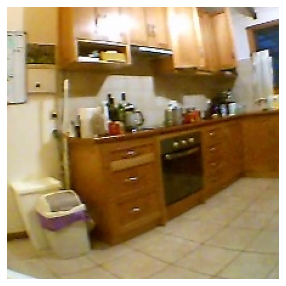

/home/ww2135/.local/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


with peas or what


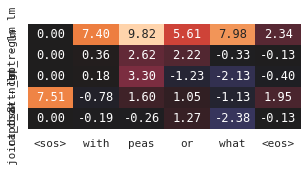

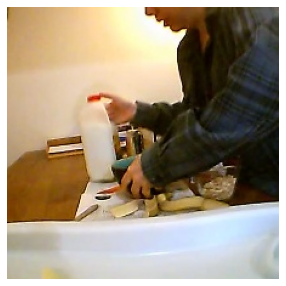

okay


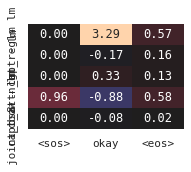

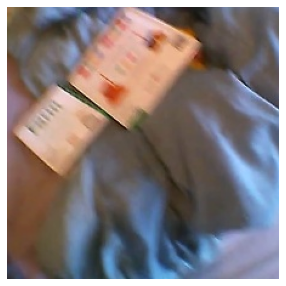

yay


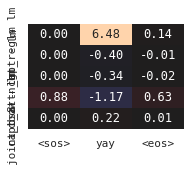

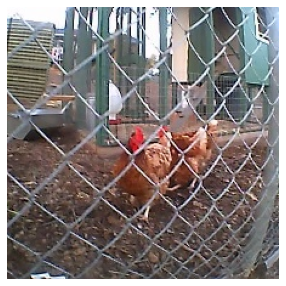

yeah they're chickens


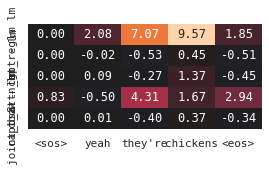

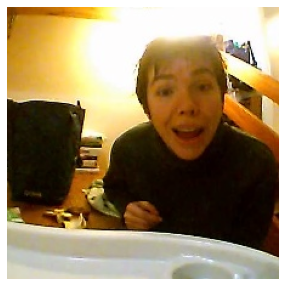

yeah that’s right yummy banana


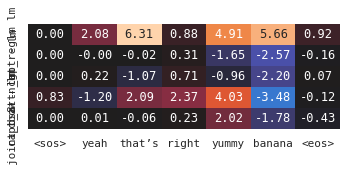

In [10]:
searched_word = None
visualize_models = False
n_print_example = 5
textgen_model_ns = [model_n for model_n, (name, model) in enumerate(zip(names, models)) if 'attn' in name] if False else []
multiple_views = False
all_steps = False

gradcam_model_ns = [model_n for model_n, model in enumerate(models) if model.text_encoder.captioning or model.text_encoder.has_attention]
attn_model_ns = [model_n for model_n, model in enumerate(models) if model.text_encoder.has_attention]
if not visualize_models:
    gradcam_model_ns = []
    attn_model_ns = []
n_visualized_models = len(gradcam_model_ns) + len(attn_model_ns)

if searched_word:
    if searched_word is True:
        searched_word = input("search word: ")
    searched_token_id = word2idx.get(searched_word, UNK_TOKEN_ID)
    if searched_token_id == UNK_TOKEN_ID:
        print(f"mapping {searched_word} to UNK")


def get_views(x, grid=(2, 2)):
    """Get multiple views of image x.
    """
    img = n_inv(x)
    views = [img]
    h = img.size(-2) // grid[0]
    w = img.size(-1) // grid[1]
    for grid_i in range(grid[0]):
        for grid_j in range(grid[1]):
            x = grid_i * h
            y = grid_j * w
            views.append(resized_crop(img, x, y, h, w, img.shape[-2:]))
    views = list(map(normalizer, views))
    return views


show_image = functools.partial(plot_image, overlying=True, blur=False, interpolation='nearest')


def visualize_example(x, y, y_len, raw_y, steps=None, model_first=True, prepend_x=False, use_losses_from_example_i=None):
    """Visualize an example.
    Inputs:
        steps: list of steps to visualize; None for all steps
        model_first: if True, then the axes are of n_visualized_models * len(steps), else it is transposed
        prepend_x: if True, prepend raw image x before the models
        use_losses_from_example_i: use losses from model_items; if None, use the losses generated by running the models
    """
    img = torch_to_numpy_image(n_inv(x))
    y_labels = [idx2word[y_id.item()] for y_id in y]
    if steps is None:
        steps = list(range(y_len.item()))

    n_rows, n_cols = int(prepend_x) + n_visualized_models, len(steps)
    if not model_first:
        n_rows, n_cols = n_cols, n_rows
    n_axes = n_rows * n_cols
    ax_size = 5
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(ax_size * n_cols, ax_size * n_rows), squeeze=False)
    if not model_first:
        axes = [[axes[j][i] for j in range(n_rows)] for i in range(n_cols)]
    axes_iter = itertools.chain.from_iterable(axes)

    if prepend_x:
        for step_i, step in enumerate(steps):
            show_image(next(axes_iter), img)

    for model_n in gradcam_model_ns:
        model, name = models[model_n], names[model_n]
        gradcams = gradCAM_for_captioning_lm(model, x, y, y_len, steps=steps)
        prefix = f'{name} GradCAM'
        for step_i, (step, gradcam) in enumerate(zip(steps, gradcams)):
            if step == 0:
                show_image(next(axes_iter), img, text=prefix)
            else:
                text = y_labels[step]
                if step_i == 0:
                    text = prefix + ' ' + text
                show_image(next(axes_iter), img, gradcam, text=text)

    for model_n in attn_model_ns:
        model, name = models[model_n], names[model_n]
        attns = attention_for_attention_lm(model, x, y, y_len, steps=steps)
        prefix = f'{name} attn'
        for step_i, (step, attn) in enumerate(zip(steps, attns)):
            text = y_labels[step]
            if step_i == 0:
                text = prefix + ' ' + text
            show_image(next(axes_iter), img, attn, text=text)

    for ax in axes_iter:
        ax.axis("off")
    plt.show()

    if use_losses_from_example_i is None:
        with torch.no_grad():
            losses = [get_outputs_and_loss(model, x, y, y_len, single_example=True)[1].cpu().numpy() for model in models]
    else:
        losses = [model_items[model_n].losses[use_losses_from_example_i] for model_n in range(len(model_items))]
    print(raw_y[0])
    names_, losses_ = zip(*[(name, loss) for name, loss in zip(names, losses) if 'contrastive' not in name])
    plot_loss_heatmap(names_, losses_, y_labels)


def examples_from_dataloader(dataloader):
    return itertools.chain.from_iterable((zip(*batch) for batch in dataloader))


examples = examples_from_dataloader(dataloader_fn())

example_i = 0
print_example_i = 0

for example_i, (x, y, y_len, raw_y) in enumerate(examples):
    y = y[:y_len]

    if searched_word:
        searched_word_steps = [idx for idx, y_id in enumerate(y) if y_id == searched_token_id]
        if not searched_word_steps:
            continue

    if all_steps:
        steps = None
    else:
        steps = searched_word_steps if searched_word else [0]

    for x_view_i, x_view in enumerate(get_views(x) if multiple_views else [x]):
        visualize_example(x_view, y, y_len, raw_y, steps=steps, model_first=all_steps, prepend_x=not all_steps)

    for model_n in textgen_model_ns:
        name = names[model_n]
        print(f"generating text from {name}:")
        model = models[model_n]
        image_features, image_feature_map = model.model.encode_image(x.unsqueeze(0).to(device))
        beam_seq, log_prob = model.language_model.beam_search_decode(
            batch_size=1,
            beam_width=model.beam_width,
            decode_length=model.decode_length,
            length_penalty_alpha=model.length_penalty_alpha,
            image_features=image_features if model.language_model.text_encoder.captioning else None,
            image_feature_map=image_feature_map if model.language_model.text_encoder.has_attention else None,
        )
        gen_text_ids = beam_seq[0, 0]
        gen_text_len = len(gen_text_ids)
        while gen_text_len > 0 and gen_text_ids[gen_text_len - 1] == PAD_TOKEN_ID:
            gen_text_len -= 1
        gen_text_len = torch.tensor(gen_text_len, device=device)
        gen_text_labels = [idx2word[y_id.item()] for y_id in gen_text_ids]
        gen_text = ' '.join(gen_text_labels)
        visualize_example(x, gen_text_ids, gen_text_len, [gen_text], steps=None, model_first=True, prepend_x=False)

    print_example_i += 1
    if print_example_i >= n_print_example:
        break

In [11]:
vector_attr = 'mean_vector' #'embedding'

cosine matrices:



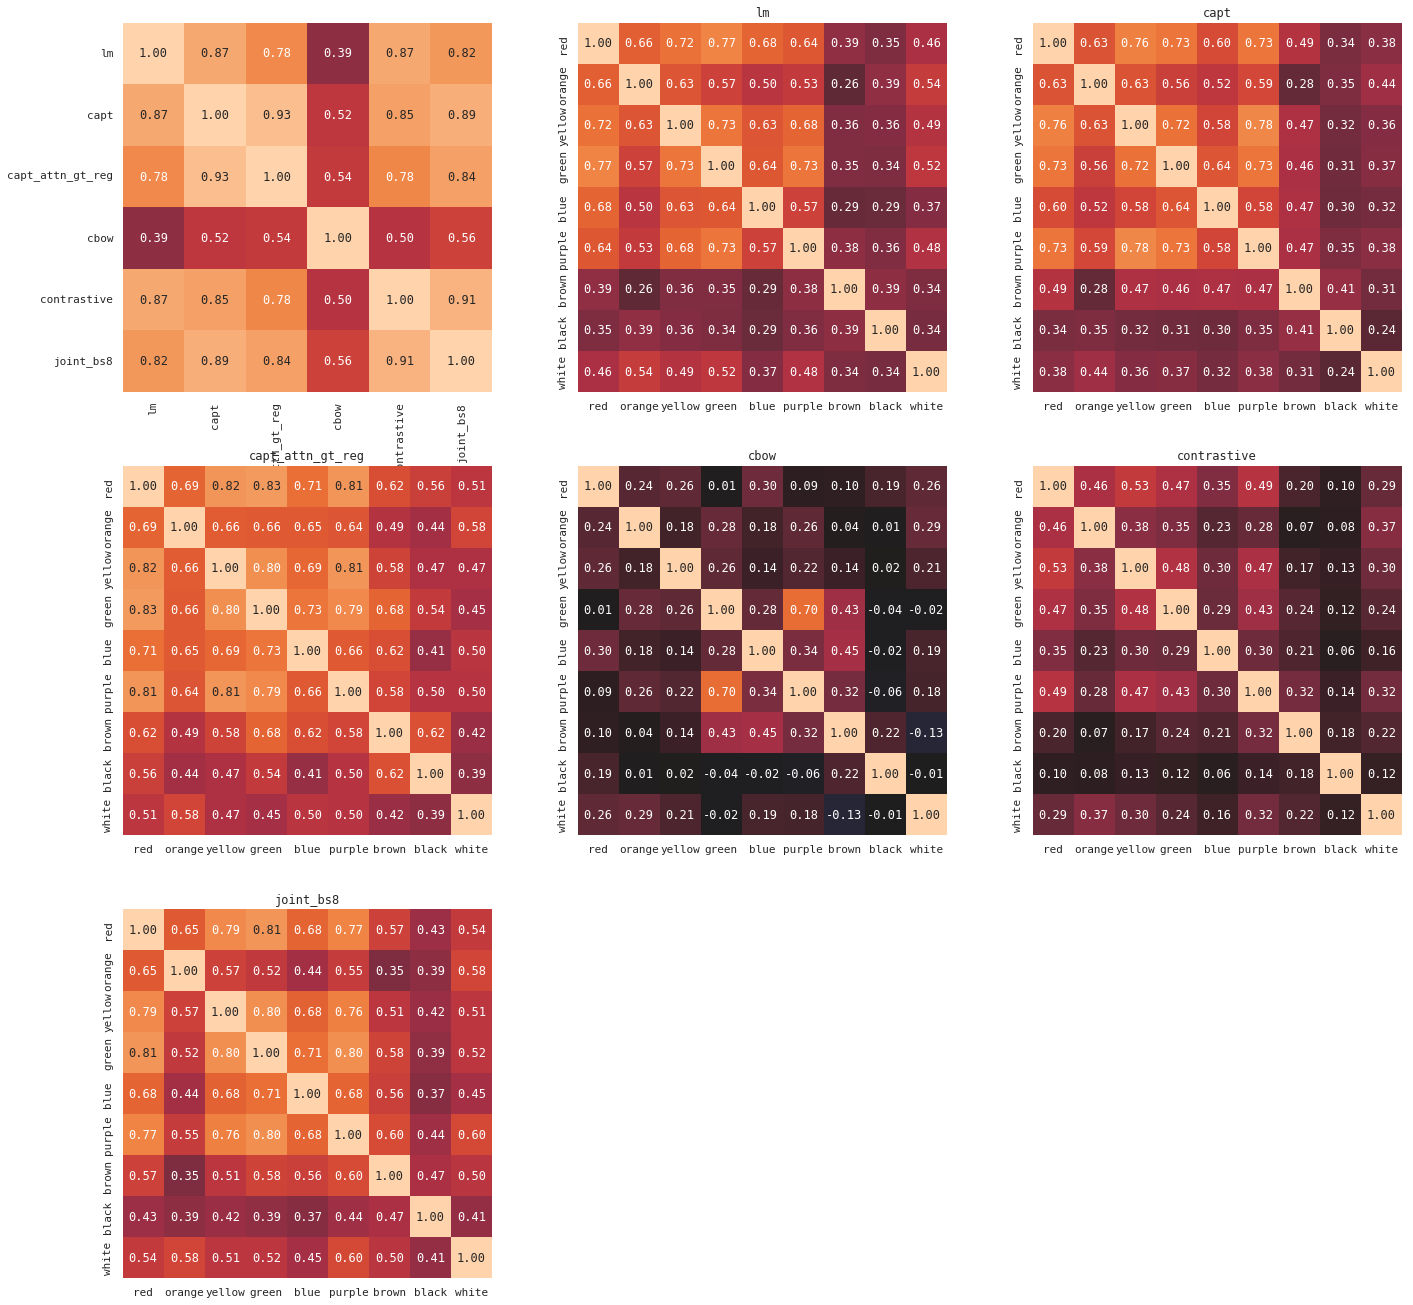

cosine matrices for the differentiations:



In [12]:
# cosine matrices for some tested words

def get_items_from_inp(inp):
    token_ids = split_tokens(inp)
    if UNK_TOKEN_ID in token_ids:
        raise KeyError
    return token_items.loc[token_ids]


# cosine matrices
print('cosine matrices:')
print()
for inp in [
    "red orange yellow green blue purple brown black white",
    "boy girl mommy daddy grandpa grandma",
]:
    try:
        items = get_items_from_inp(inp)
    except KeyError:
        continue
    plot_vector_sim_heatmap(items, vector_attr=vector_attr, one_figure=True)

# cosine matrices for the differentiations (vector1 - vector0)
print('cosine matrices for the differentiations:')
print()
for inp in [
    "do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives",
    "do did go went play played get got eat ate have had make made look looked fly flew drive drove stand stood crawl crawled",
    "do doing go going play playing get getting eat eating have having look looking fly flying drive driving stand standing crawl crawling",
    "do don't does doesn't did didn't should shouldn't has hasn't have haven't will won't",
    "boy girl mommy daddy grandpa grandma",
]:
    try:
        items = get_items_from_inp(inp)
    except KeyError:
        continue
    plot_vector_sim_heatmap(items, diff=True, vector_attr=vector_attr, one_figure=True)

In [13]:
extend_items(token_items)

for n, name in enumerate(names):
    print(f'{name}:')
    get_tsne_points(token_items[name], get_attr=vector_attr)
    extend_point_items(token_items, name, 'tsne')
    get_eigen_points(token_items[name], get_attr=vector_attr)
    extend_point_items(token_items, name, 'eigen')

lm:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
capt:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
capt_attn_gt_reg:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
cbow:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
contrastive:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
joint_bs8:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.


In [14]:
untypical_tokens = """
<unk>
let's
let’s
lets
lot
lots
bit
one
yeahh
is
isn't
isn’t
isnt
was
wasn't
wasn’t
wasnt
are
aren't
aren’t
arent
were
weren't
weren’t
werent
am
be
i'm
i’m
im
you're
you’re
youre
we're
we’re
were
they're
they’re
theyre
he's
he’s
hes
she's
she’s
shes
it's
it’s
i've
i’ve
ive
you've
you’ve
youve
we've
we’ve
weve
i'll
i’ll
you'll
you’ll
we'll
we’ll
he'll
he’ll
she'll
she’ll
it'll
it’ll
do
don't
don’t
dont
does
doesn't
doesn’t
doesnt
did
didn't
didn’t
didnt
here's
here’s
heres
there's
there’s
theres
that's
that’s
thats
what's
what’s
whats
where's
where’s
wheres
looking
rub
boop
bye
love
""".strip().split('\n')

top_token_items = token_items.sort_values('cnt', ascending=False, kind='stable')
top_token_items = top_token_items[~top_token_items[token_field].isin(untypical_tokens)]  # remove untypical tokens
pos_field = 'pos2'
pos_items = {pos: top_token_items[top_token_items[pos_field] == pos] for pos in top_token_items.dtypes[pos_field].categories}
for pos, items in pos_items.items():
    print(f'number of {pos}s: {len(items)}')
used_poses = list(pos_items.keys())

interleaving_step = 1

pos_pos_items = {}
for i_pos in range(len(used_poses)):
    for j_pos in range(len(used_poses)):
        if i_pos != j_pos:
            pos_i = used_poses[i_pos]
            pos_i_items = pos_items[pos_i]
            pos_j = used_poses[j_pos]
            pos_j_items = pos_items[pos_j]
            interleaved_dfs = []
            i = -interleaving_step
            for i in range(0, min(len(pos_i_items), len(pos_j_items)), interleaving_step):
                interleaved_dfs.append(pos_i_items[i:i+interleaving_step])
                interleaved_dfs.append(pos_j_items[i:i+interleaving_step])
            else:
                i += interleaving_step
                interleaved_dfs.append(pos_i_items[i:])
                interleaved_dfs.append(pos_j_items[i:])
            pos_pos_items[(pos_i, pos_j)] = pd.concat(interleaved_dfs)

interleaved_dfs = []
for i in range(0, max(map(len, pos_items.values())), interleaving_step):
    for pos in used_poses:
        items = pos_items[pos]
        interleaved_dfs.append(items[i:i+interleaving_step])
pos__items = pd.concat(interleaved_dfs)

# check some items
for _, row in top_token_items[:100].iterrows():
    print(row_str(row))
print()
for word in ['look', 'need', 'draw']:
    try:
        token_id = word2idx[word]
        for _, row in top_token_items.loc[token_id].iterrows():
            print(row_str(row))
    except KeyError:
        pass

number of .s: 67
number of adjectives: 119
number of adverbs: 70
number of cardinal numbers: 11
number of function words: 110
number of nouns: 636
number of verbs: 295
<sos>      .      1841:     1.000     1.000     1.000    12.040     1.000     1.000
<eos>      .      1830:     2.278     2.306     2.332    12.106 99999.990     2.119
you        PRP     496:     6.965     6.527     6.595     4.470 99999.990     6.532
the        DT      346:     8.333     8.625     7.212     5.274 99999.990     9.287
yeah       UH      277:    11.789    12.640    12.520     7.288 99999.990    11.462
a          DT      258:     9.619     7.607     8.062     5.139 99999.990     9.748
to         TO      256:     3.244     3.181     3.131     2.695 99999.990     3.218
and        CC      214:    19.085    13.937    14.913    19.378 99999.990    17.921
it         PRP     184:     7.947     6.800     8.331     8.599 99999.990     7.764
we         PRP     149:    15.442    14.907    14.124     6.776 99999.990   

noun_verb:


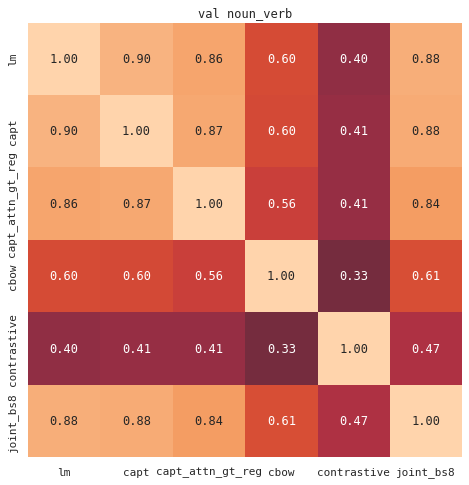

lm:


/home/ww2135/.local/lib/python3.9/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


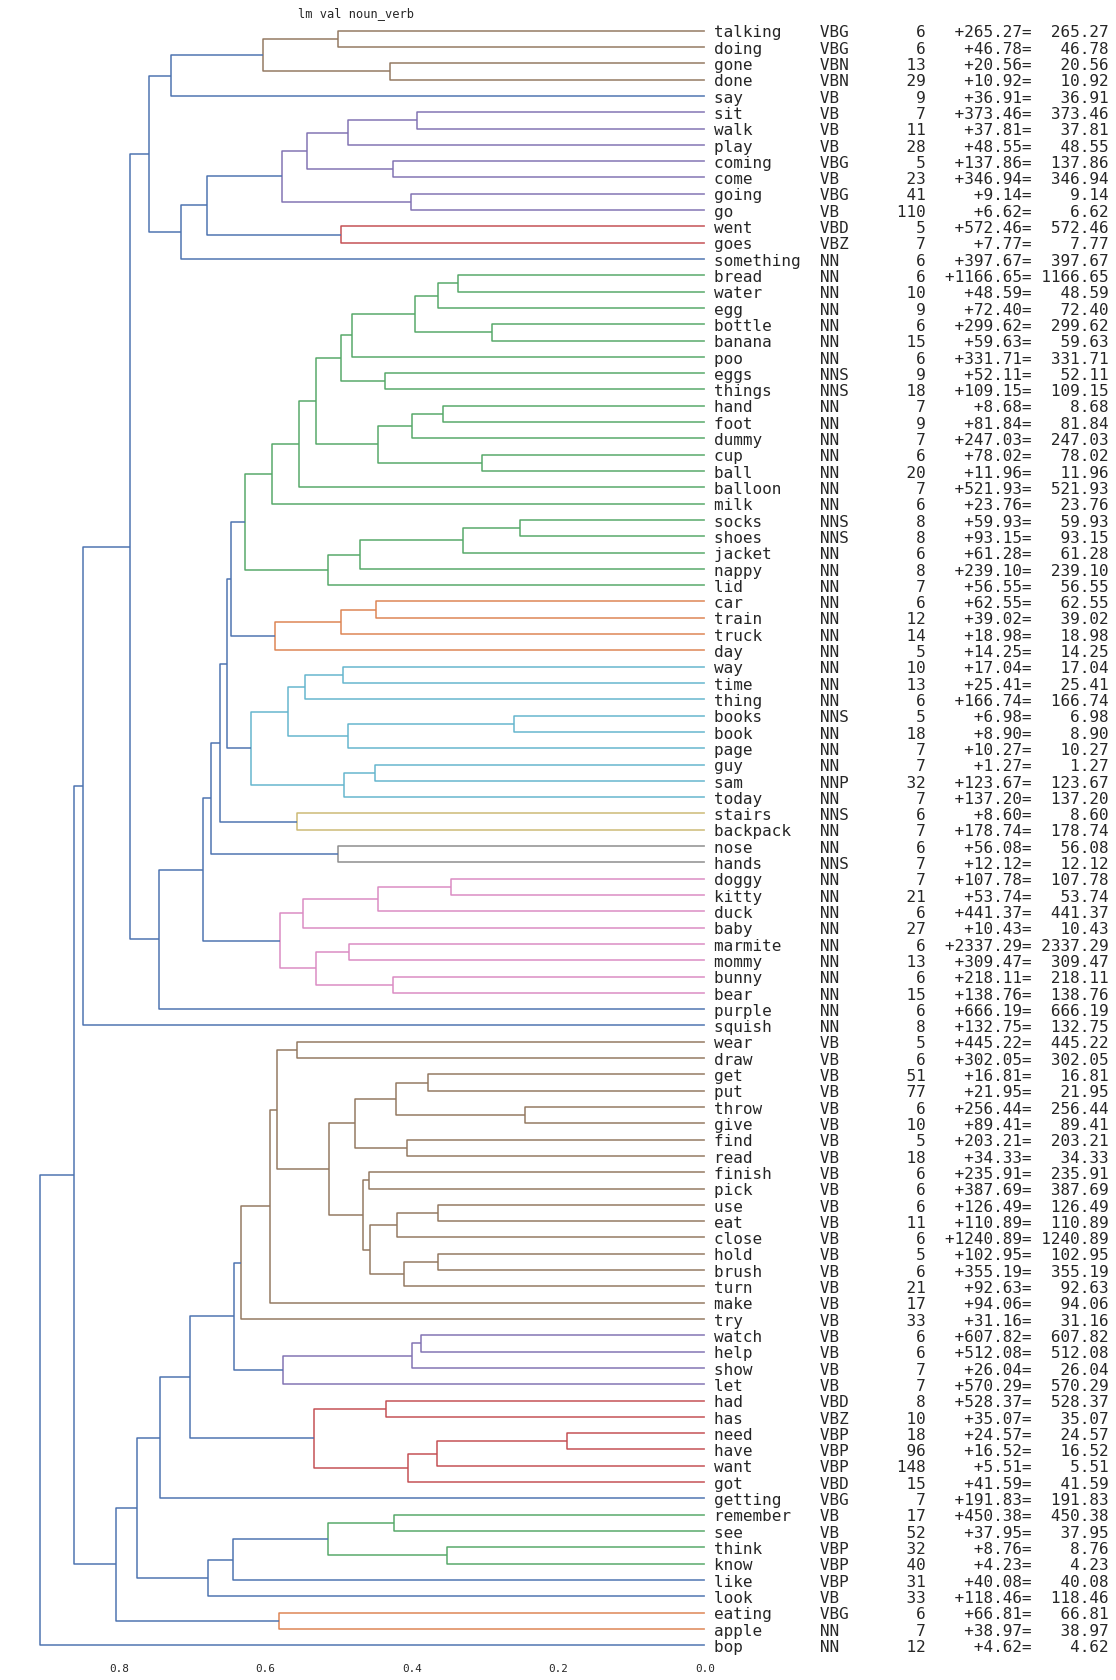

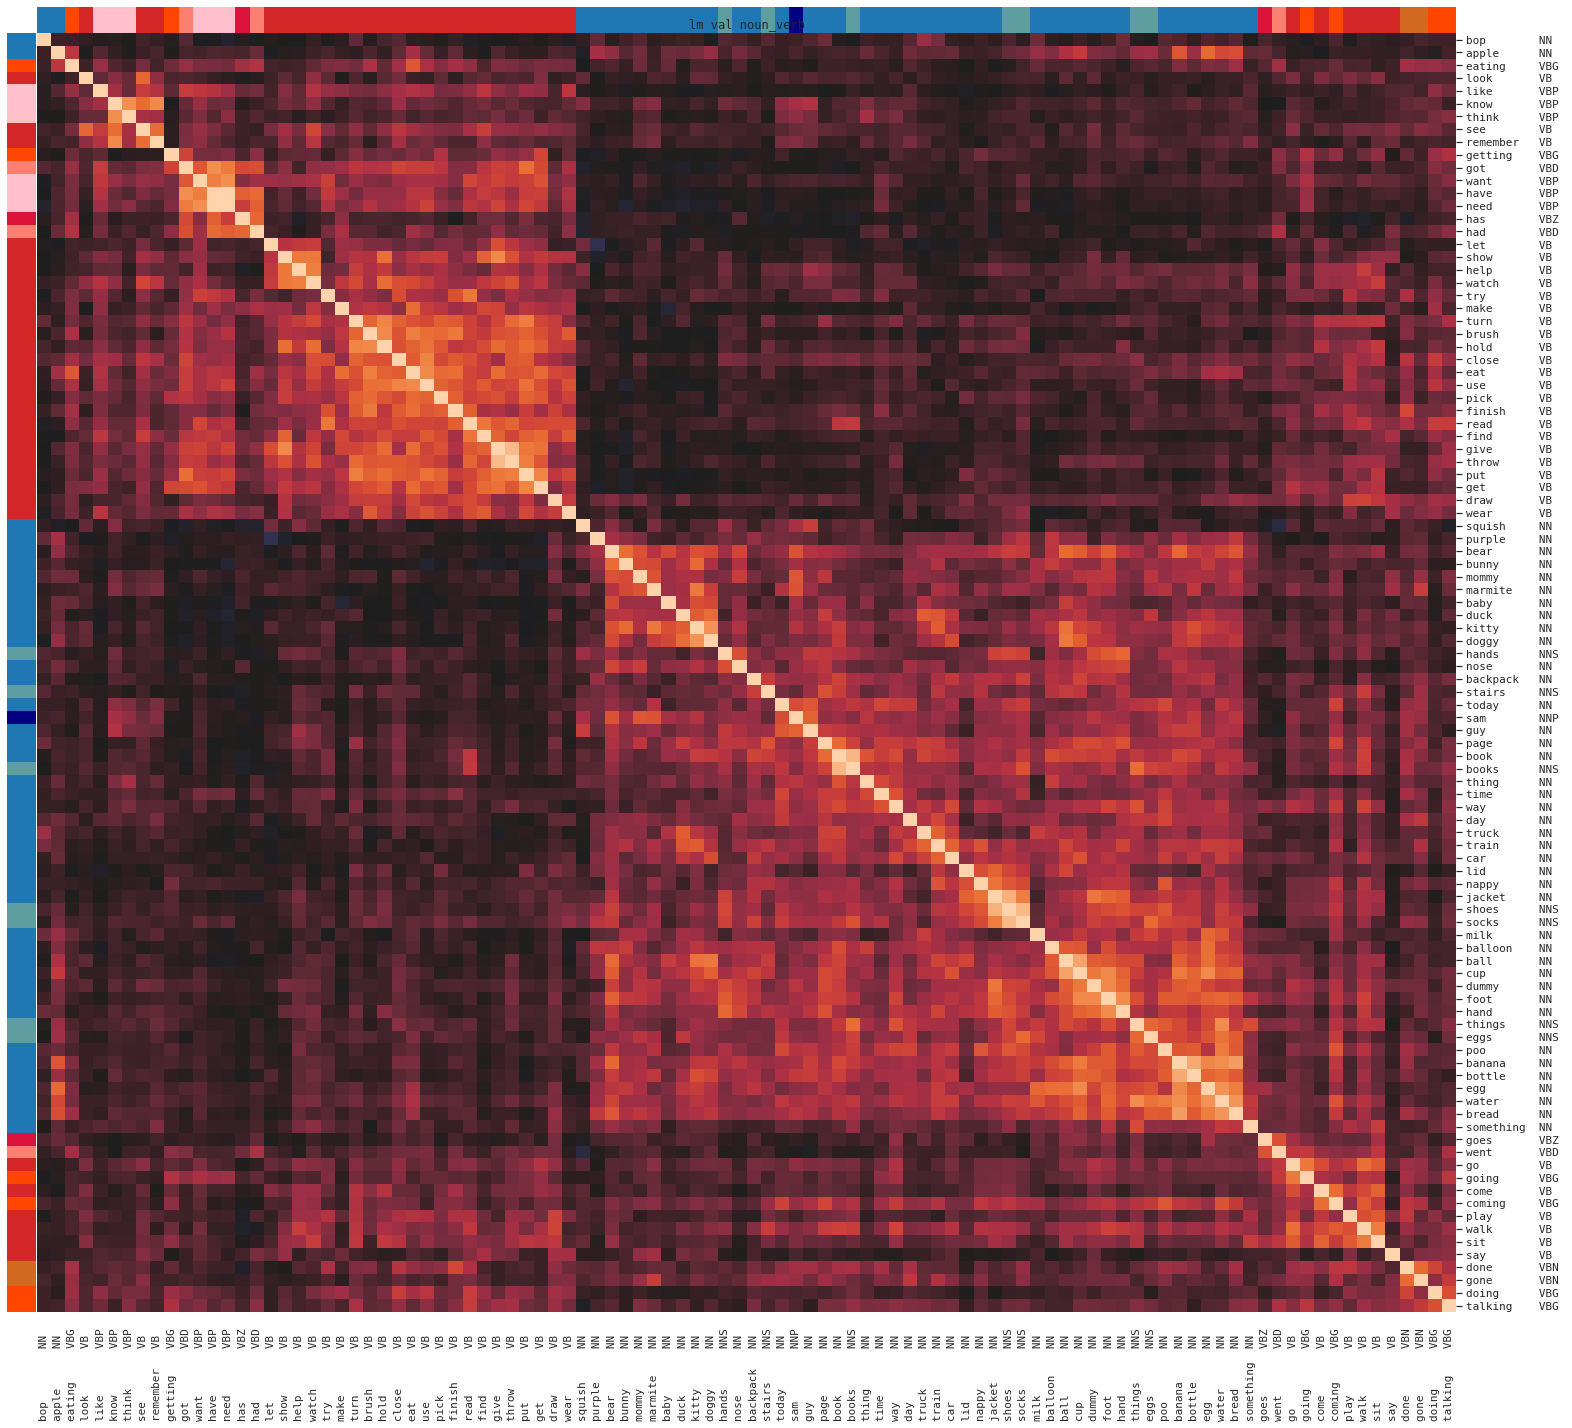

capt:


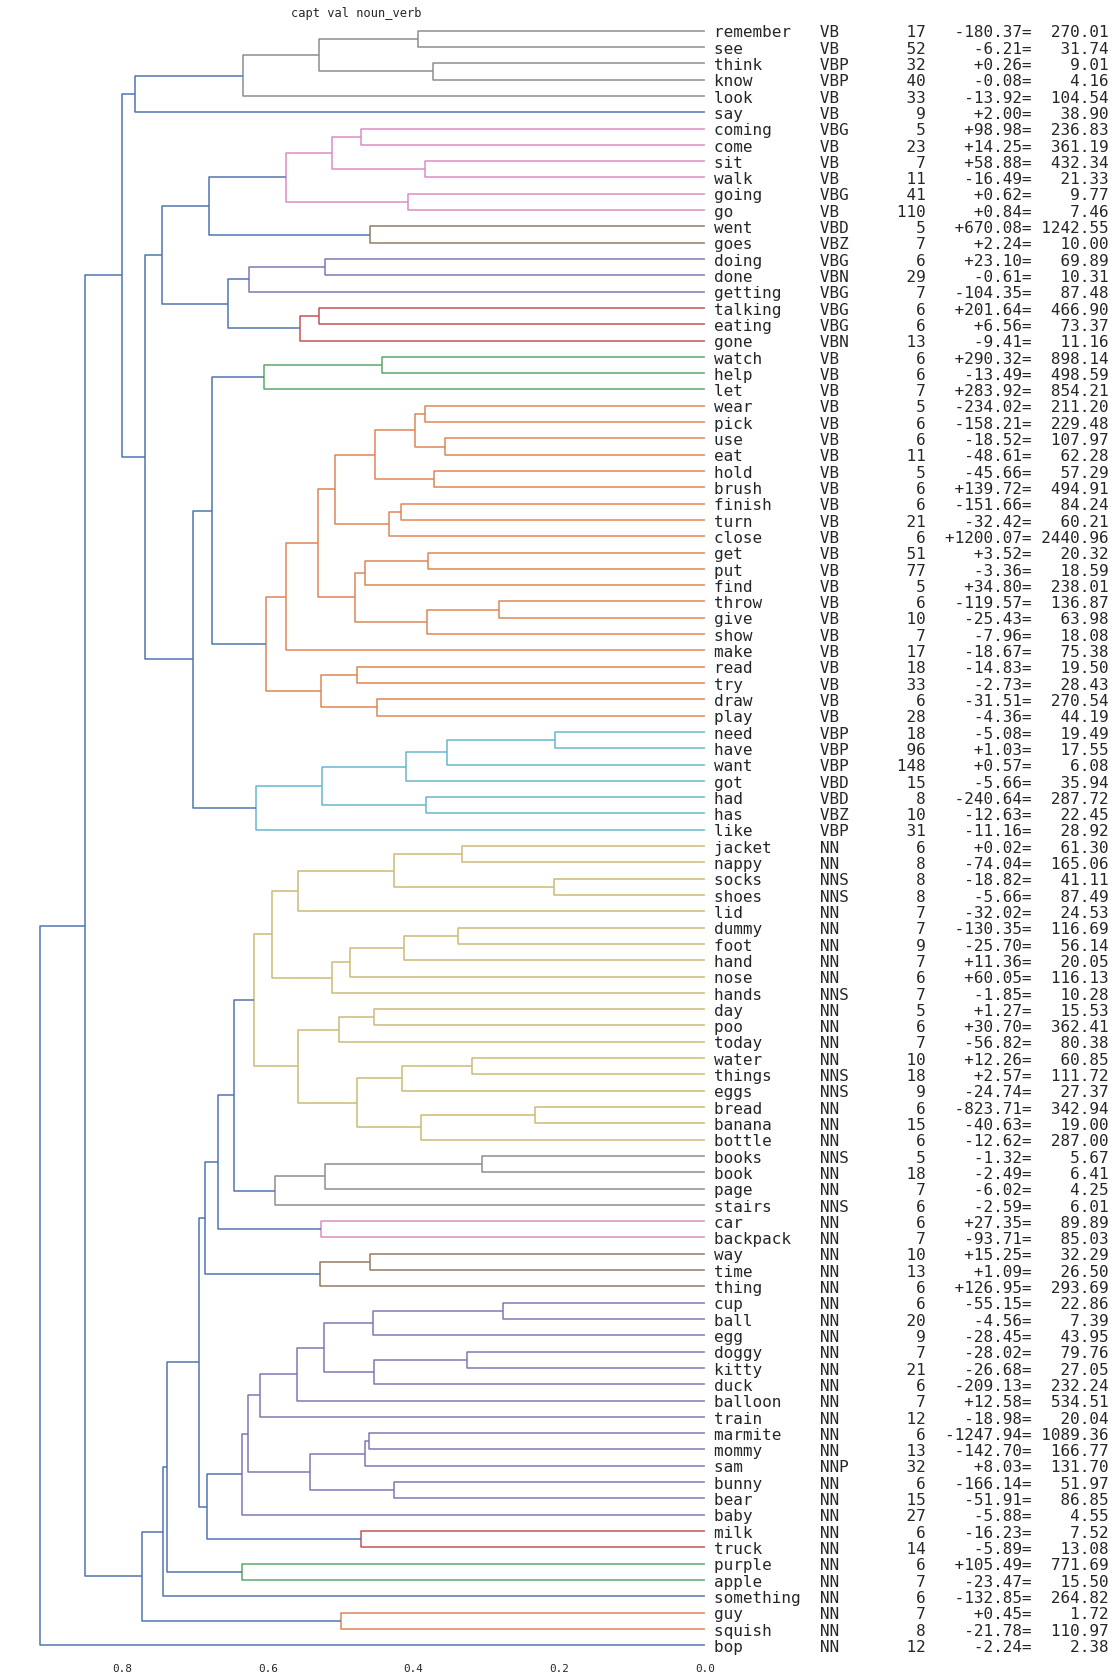

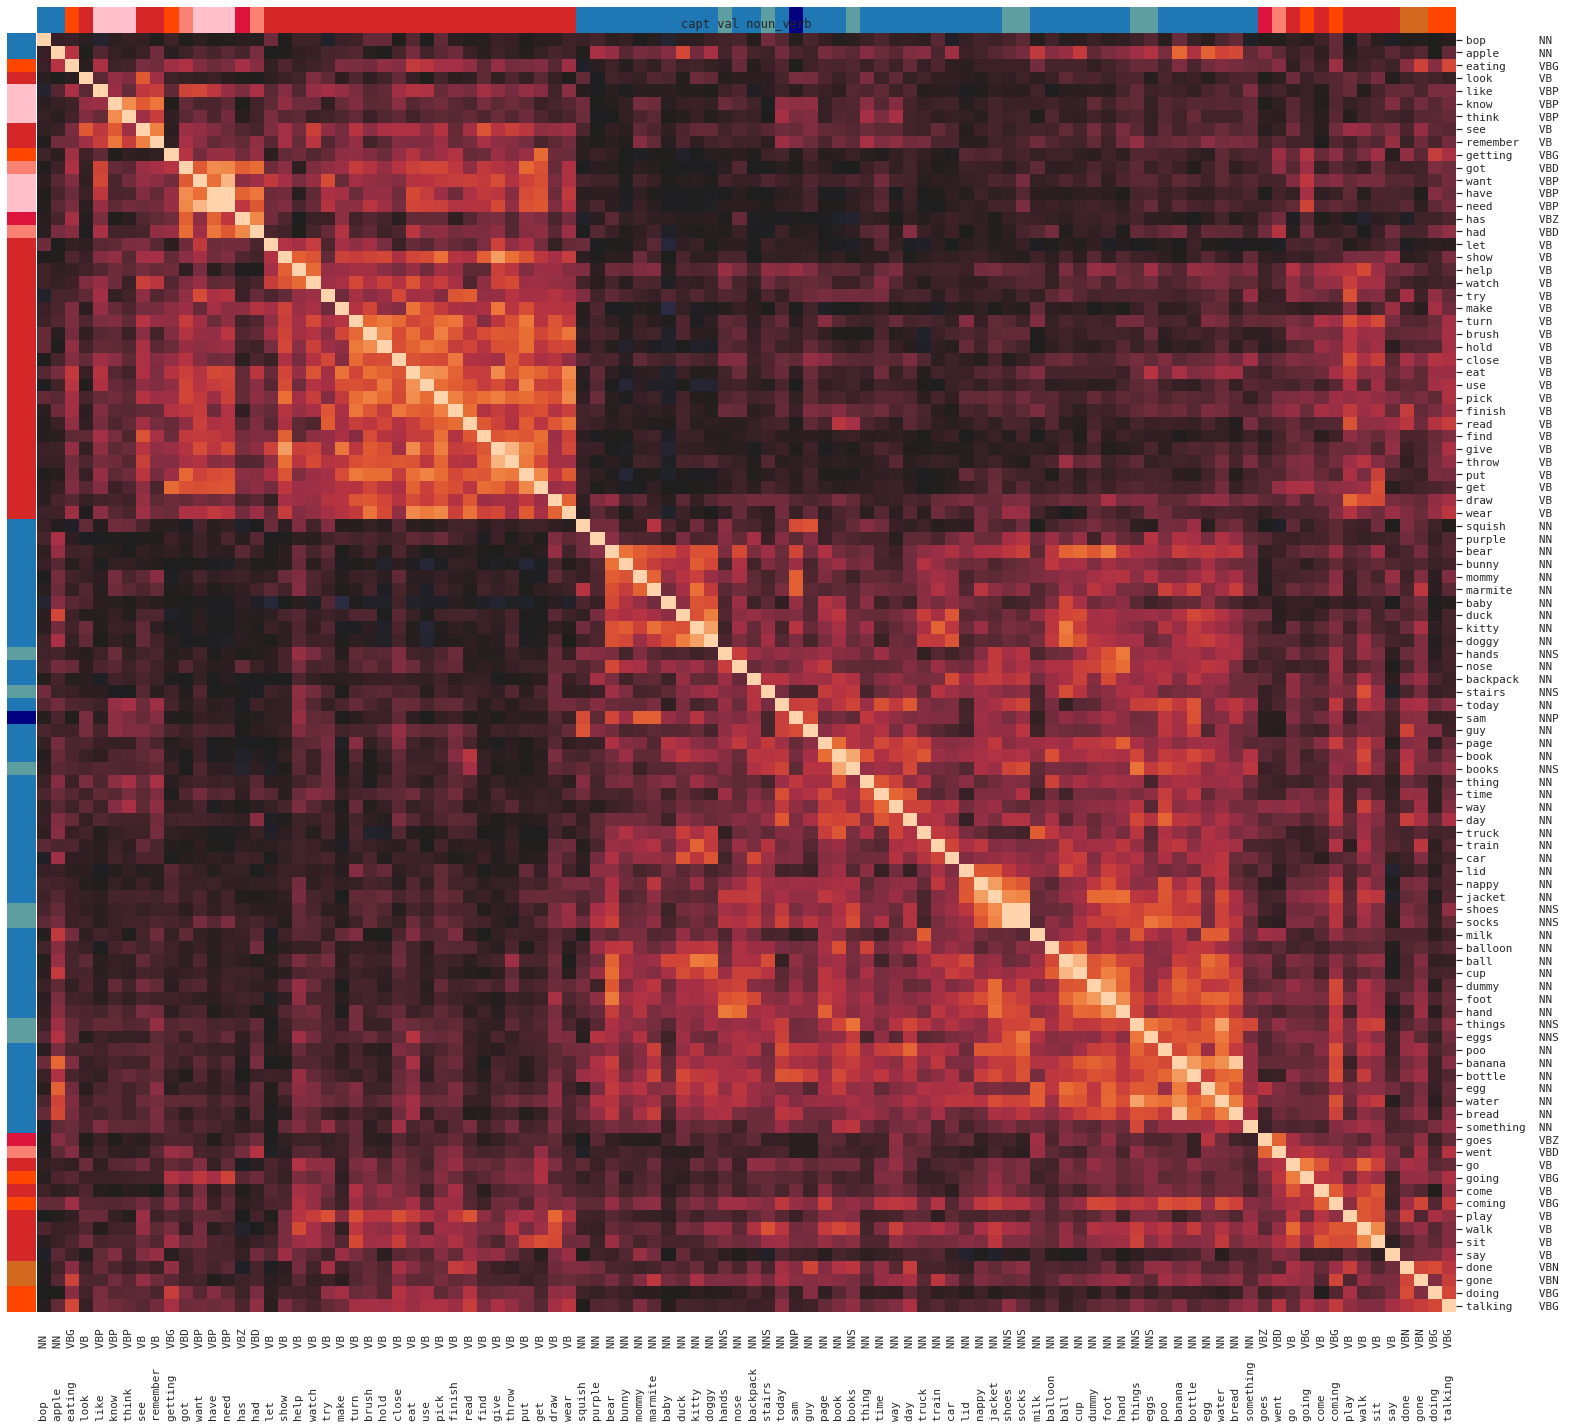

capt_attn_gt_reg:


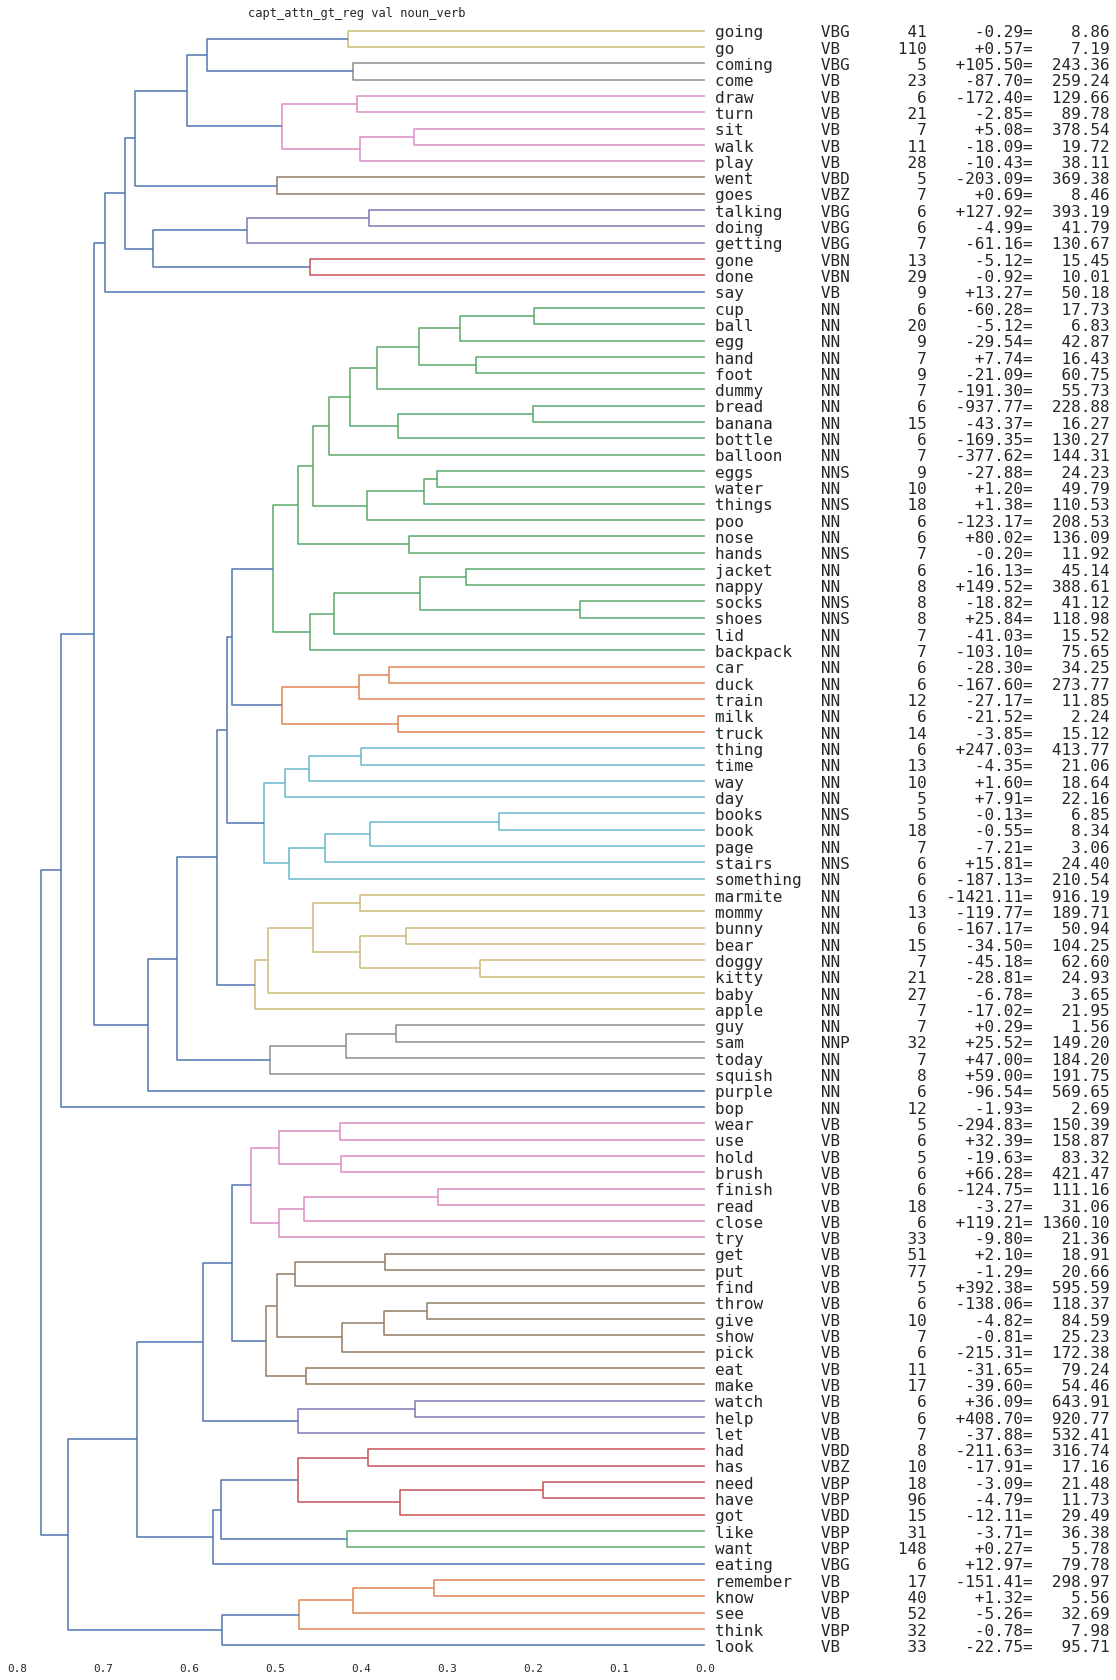

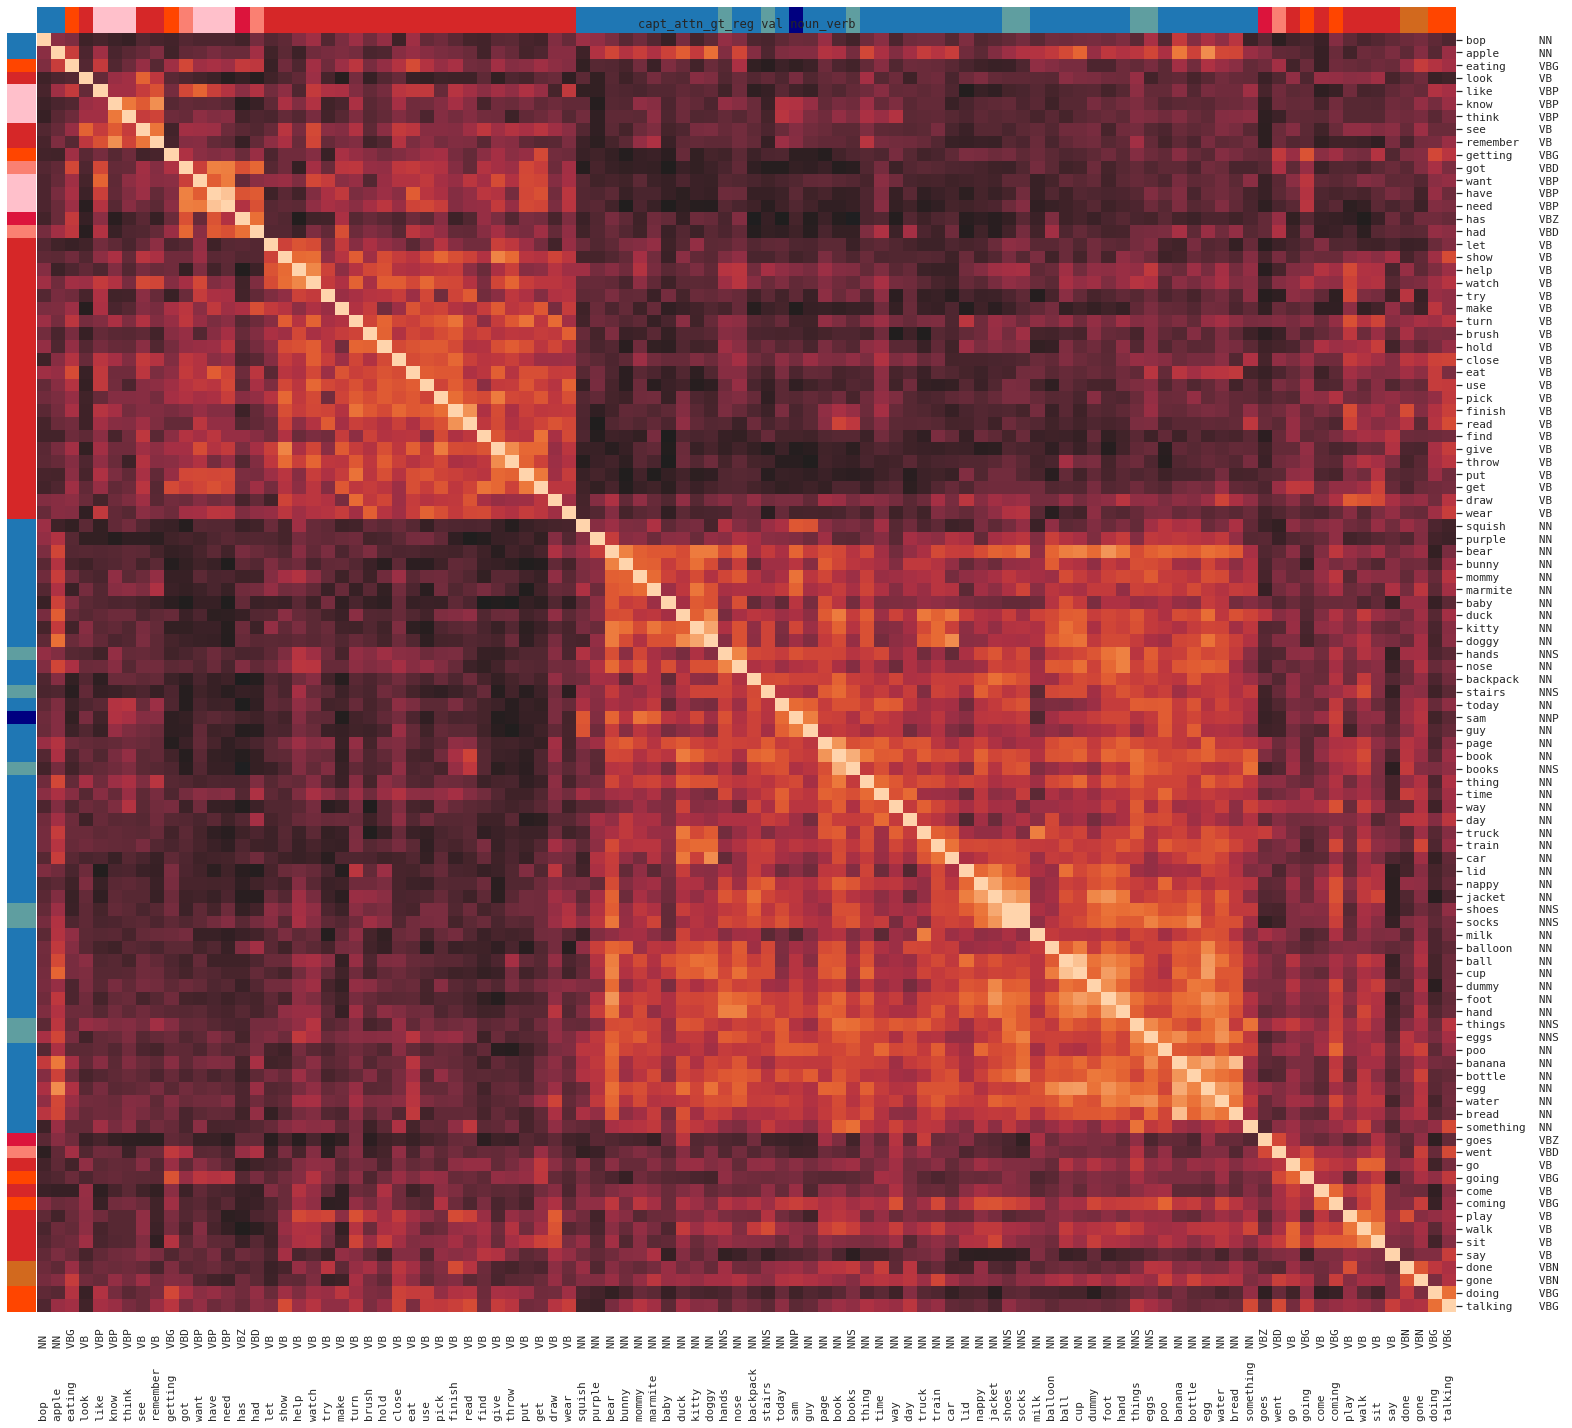

cbow:


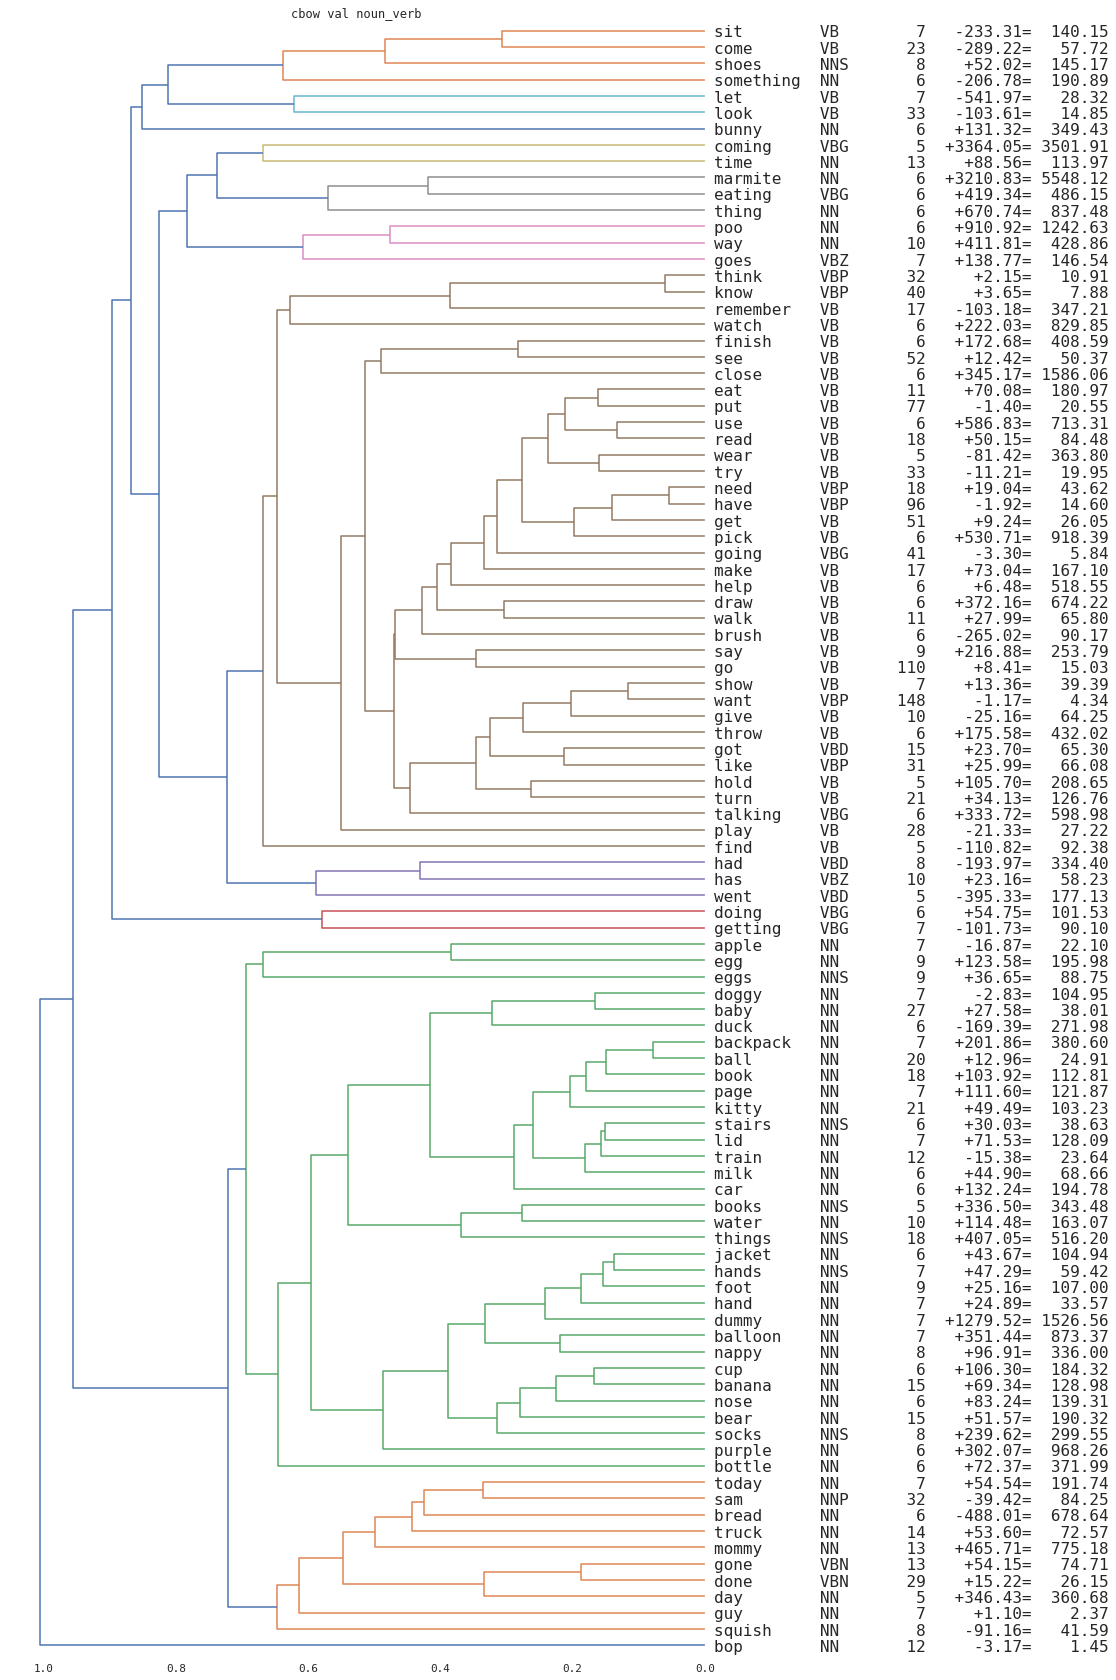

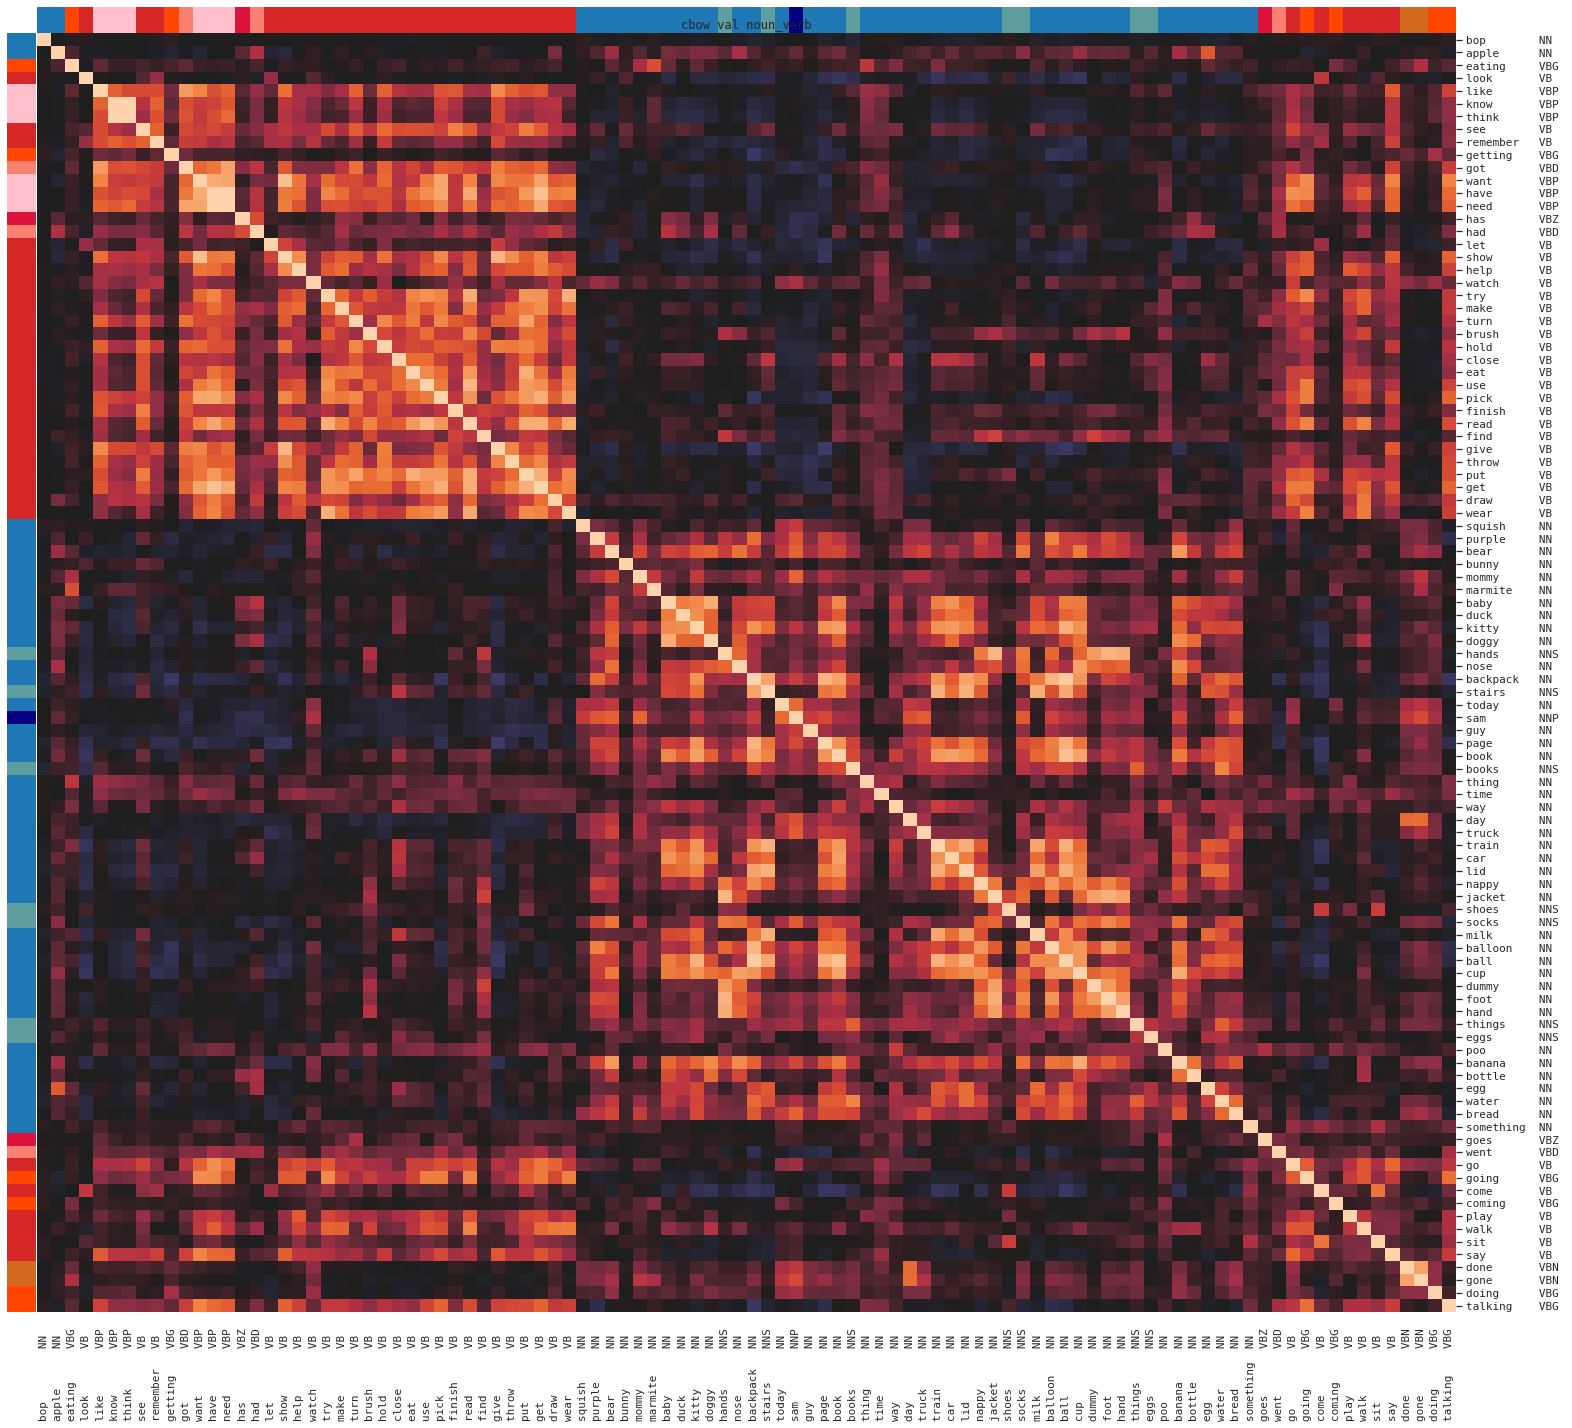

contrastive:


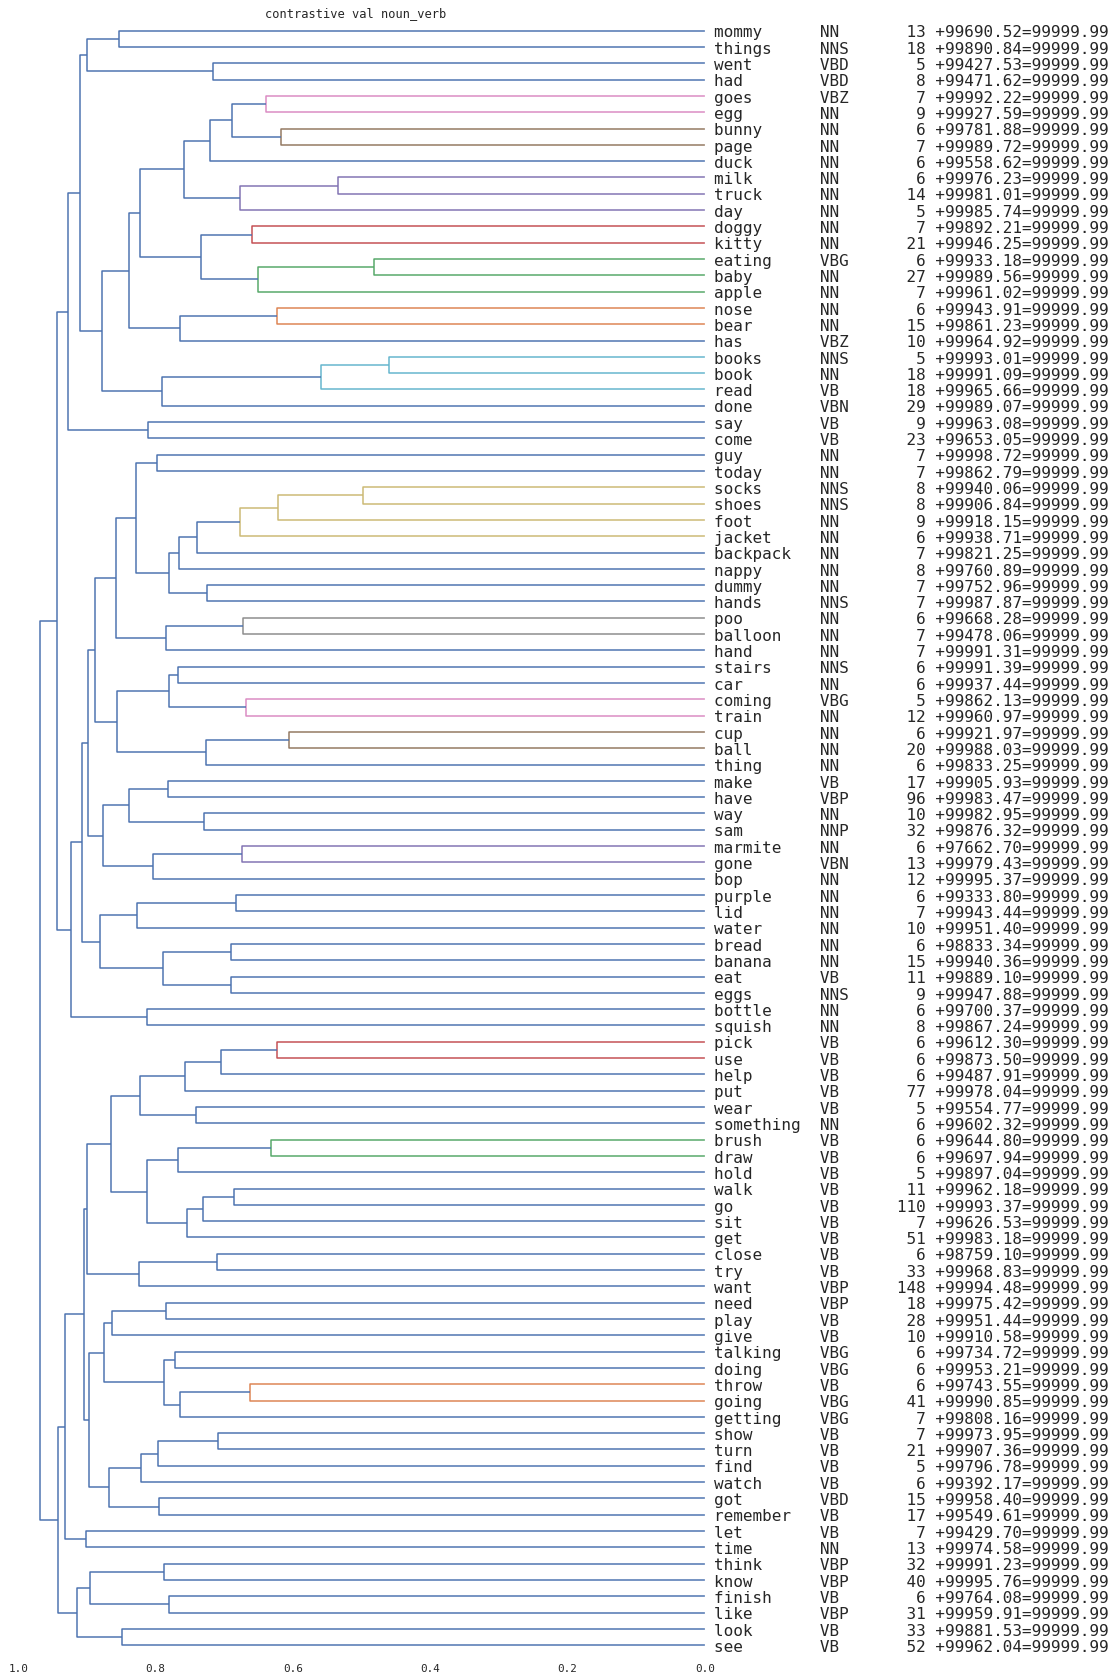

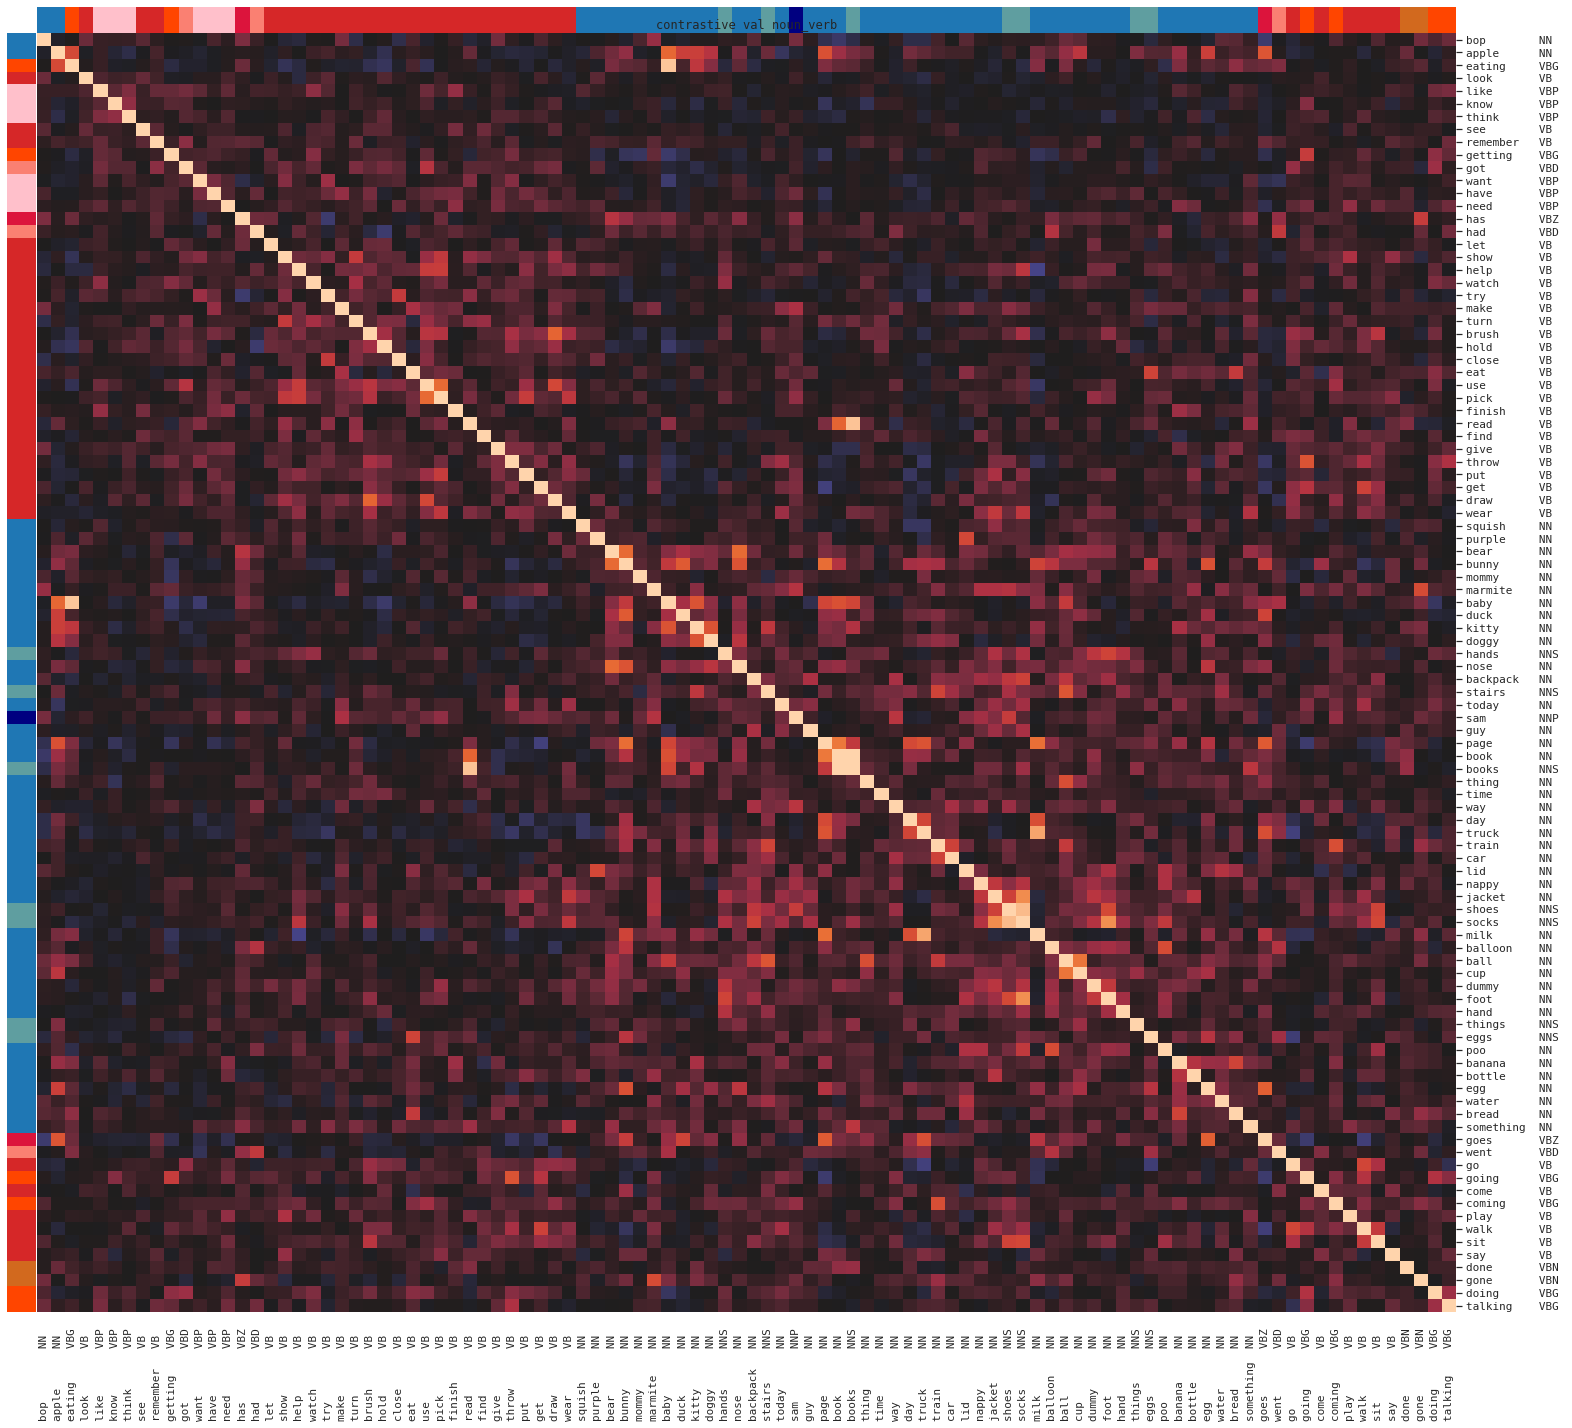

joint_bs8:


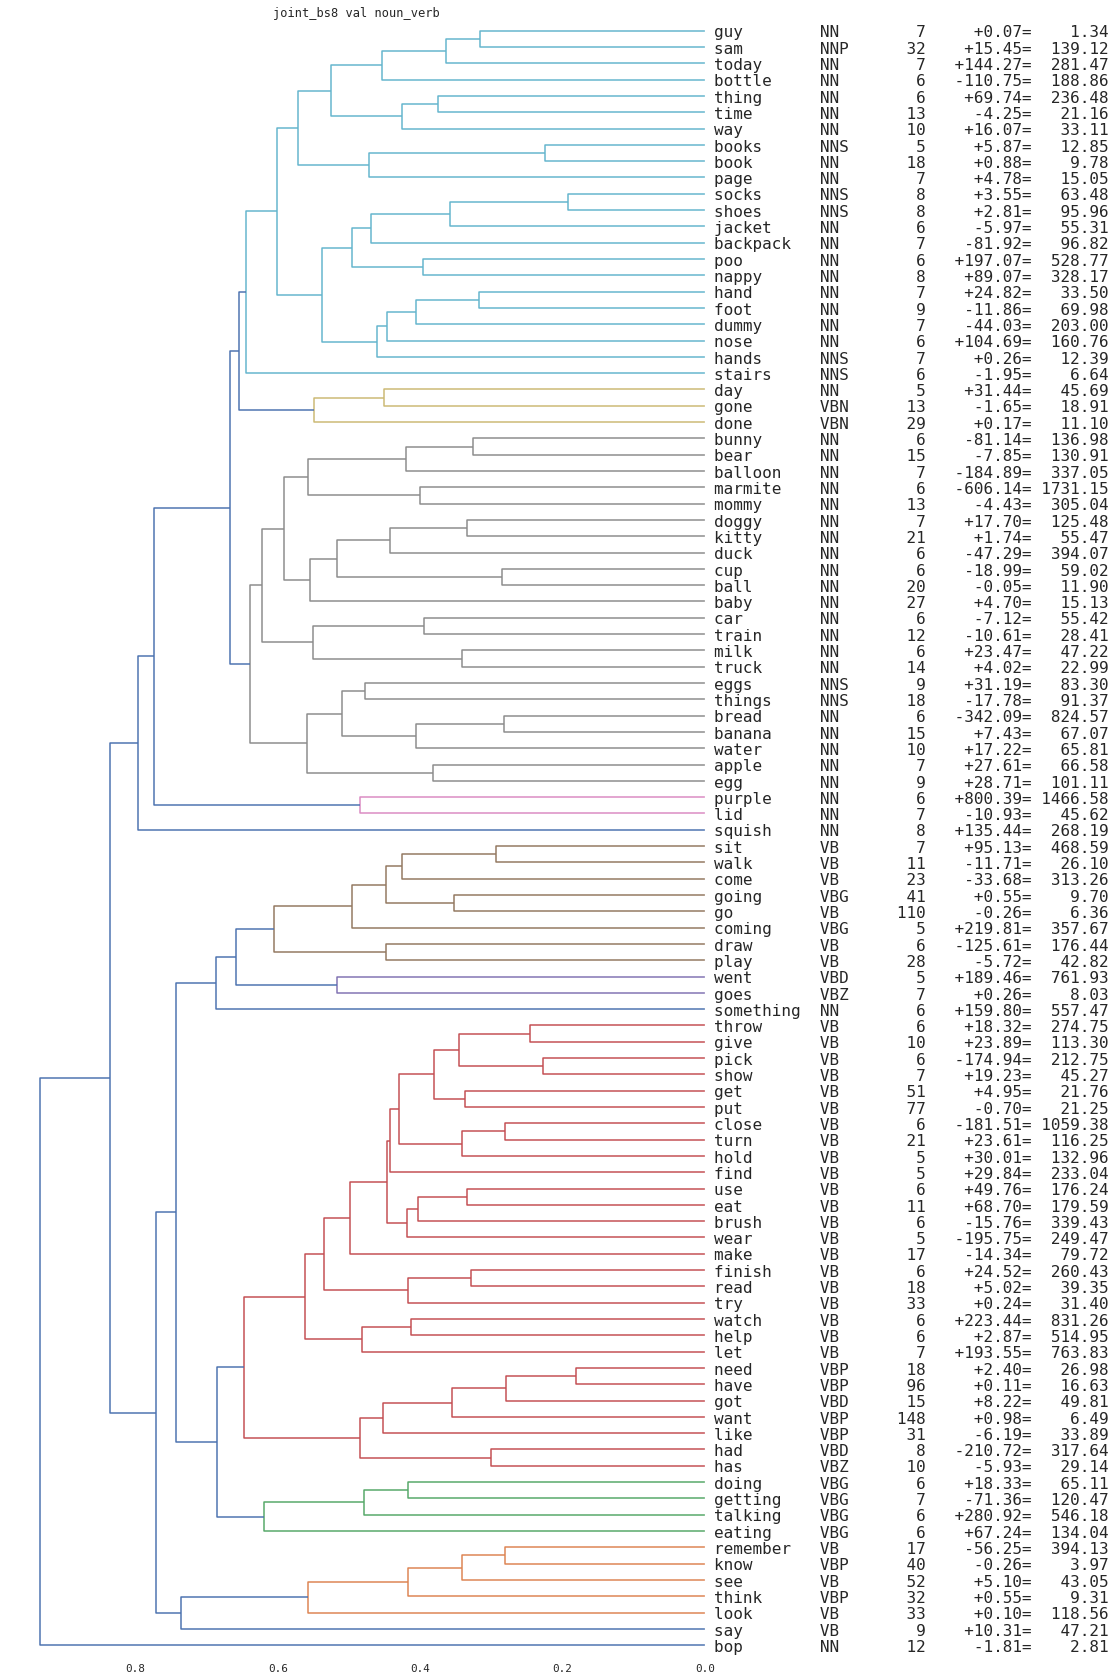

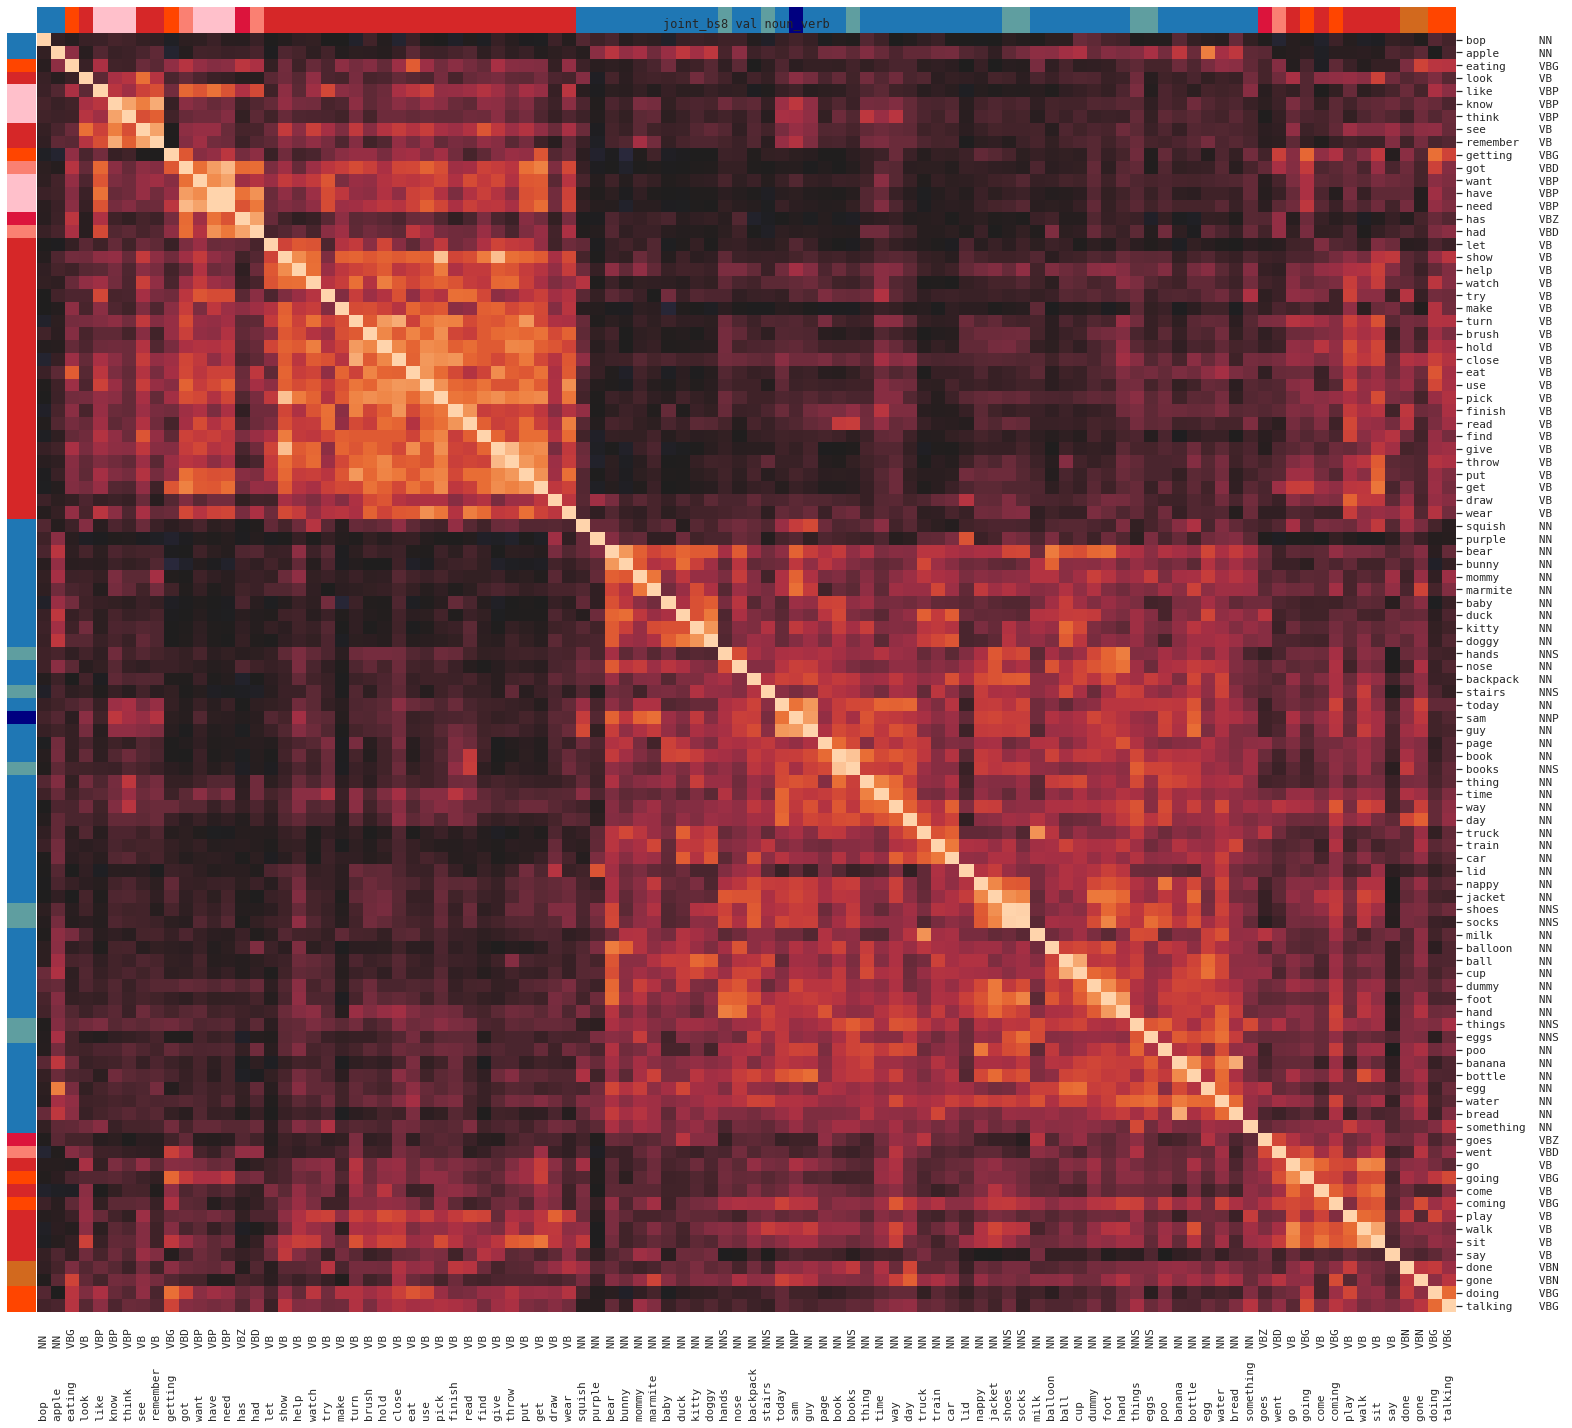

In [15]:
sns.set_theme(
    font='monospace',
    rc={
        'figure.figsize': figsize,
        'axes.grid': False,
        'axes.facecolor': 'white',
    }
)

for name, items in (('token', pos__items), ('noun_verb', pos_pos_items[('noun', 'verb')]), ('noun', pos_items['noun']), ('verb', pos_items['verb']))[1:2]:
    print(f'{name}:')
    plot_dendrogram(items[:100], heatmap=True, cluster_by_first=True, title=f'{split} {name}', vector_attr=vector_attr)

number of .s: 38
number of adjectives: 59
number of adverbs: 42
number of cardinal numbers: 5
number of function words: 81
number of nouns: 234
number of verbs: 133
plotting 2368/2368 = 100.00% items...


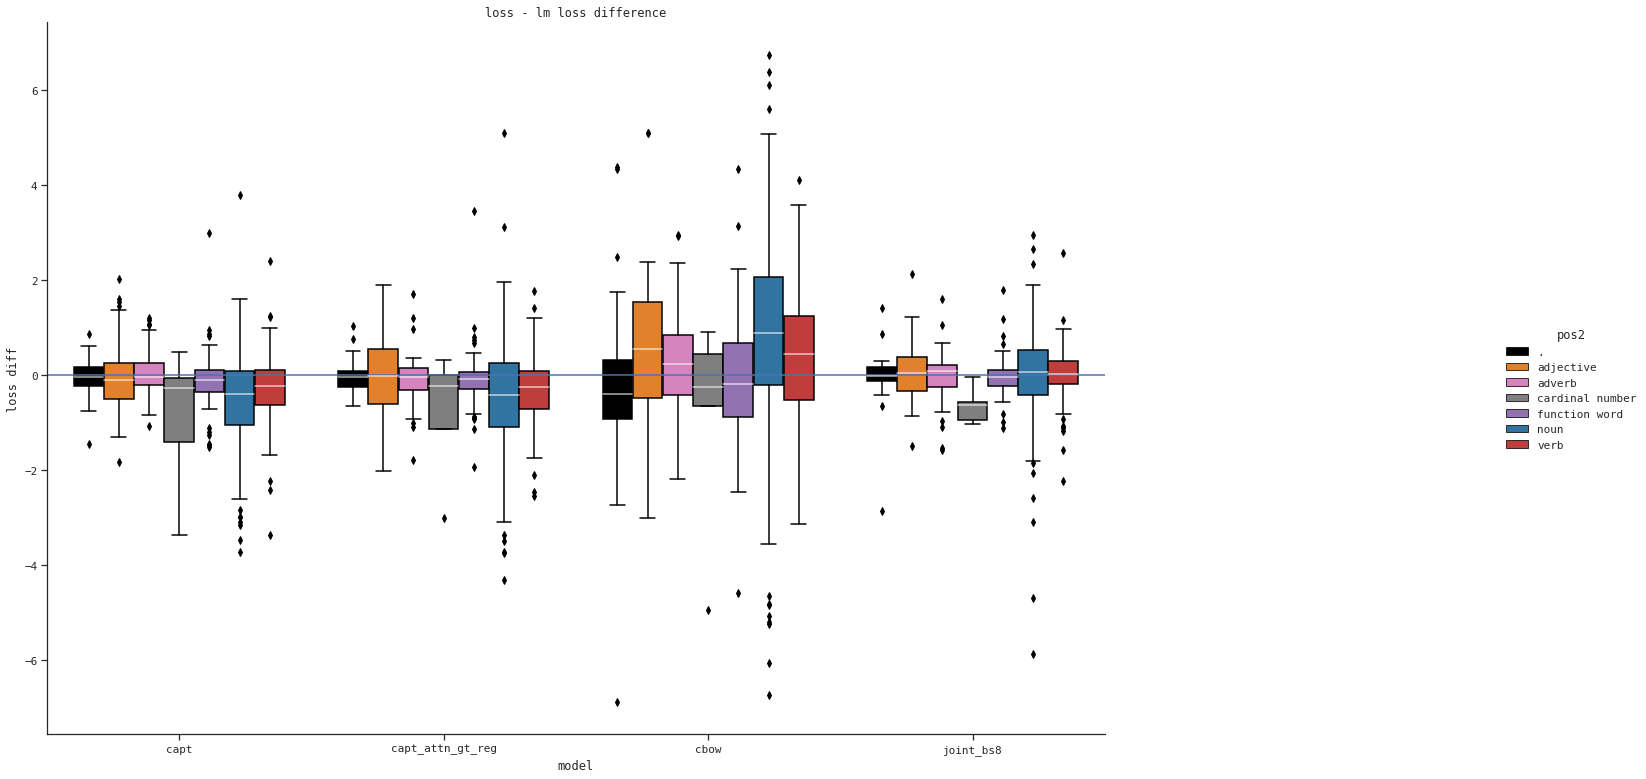

n_label_0: 234, n_label_1: 358, best_accuracy: 67.40%
best_split_accuracy: 67.40%
plotting 592/592 = 100.00% items...


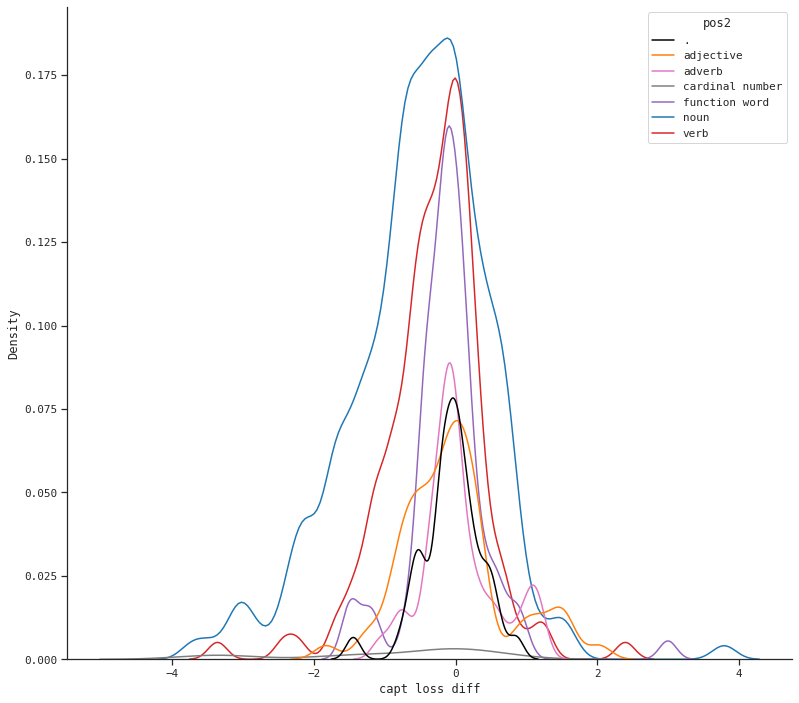

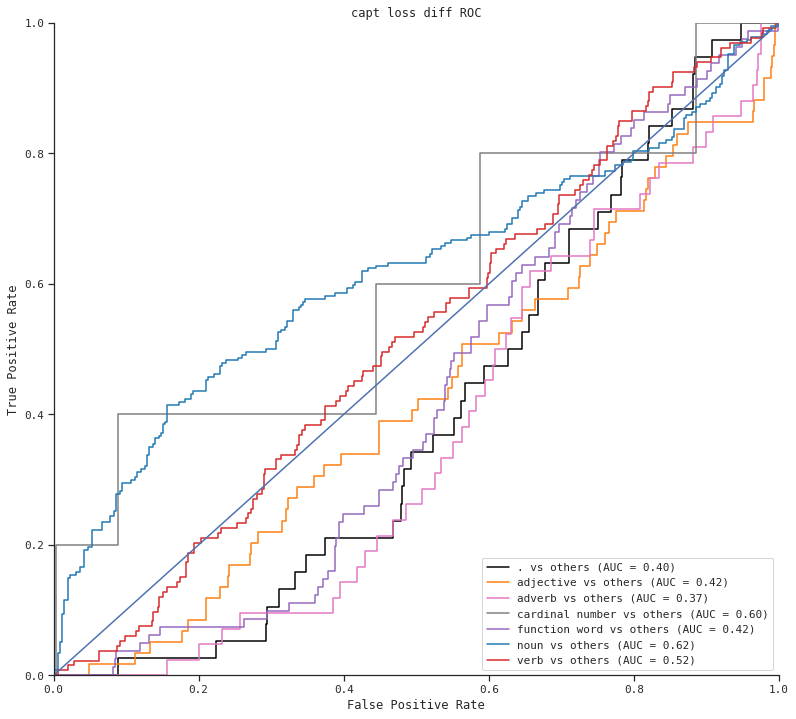

.               t-test result: statistic: -0.95 pvalue: 0.175324
adjective       t-test result: statistic: -0.28 pvalue: 0.390710
adverb          t-test result: statistic:  0.60 pvalue: 0.724192
cardinal number t-test result: statistic: -1.36 pvalue: 0.122511
function word   t-test result: statistic: -1.54 pvalue: 0.063931
noun            t-test result: statistic: -8.11 pvalue: 0.000000
verb            t-test result: statistic: -4.98 pvalue: 0.000001
all tokens      t-test result: statistic: -8.78 pvalue: 0.000000
n_label_0: 234, n_label_1: 358, best_accuracy: 65.88%
best_split_accuracy: 65.88%
plotting 592/592 = 100.00% items...


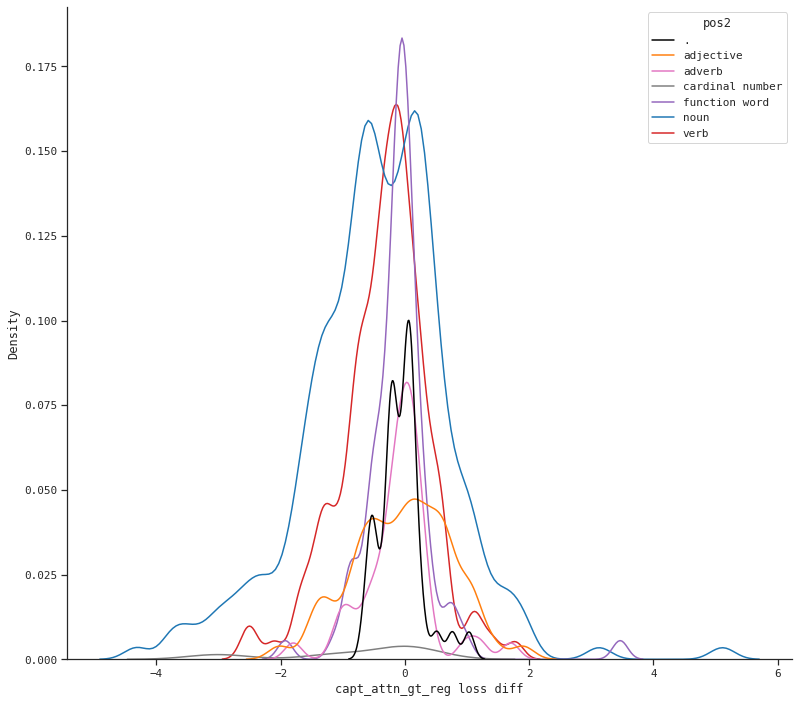

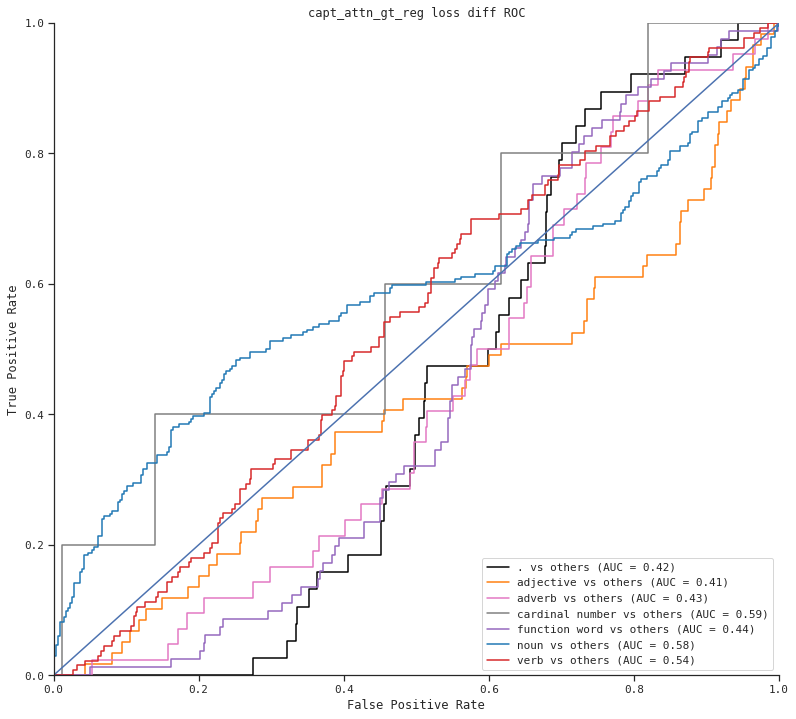

.               t-test result: statistic: -1.11 pvalue: 0.136036
adjective       t-test result: statistic: -0.39 pvalue: 0.348599
adverb          t-test result: statistic: -0.99 pvalue: 0.163741
cardinal number t-test result: statistic: -1.36 pvalue: 0.123337
function word   t-test result: statistic: -1.32 pvalue: 0.094597
noun            t-test result: statistic: -5.85 pvalue: 0.000000
verb            t-test result: statistic: -5.29 pvalue: 0.000000
all tokens      t-test result: statistic: -7.53 pvalue: 0.000000
n_label_0: 234, n_label_1: 358, best_accuracy: 61.66%
best_split_accuracy: 61.66%
plotting 592/592 = 100.00% items...


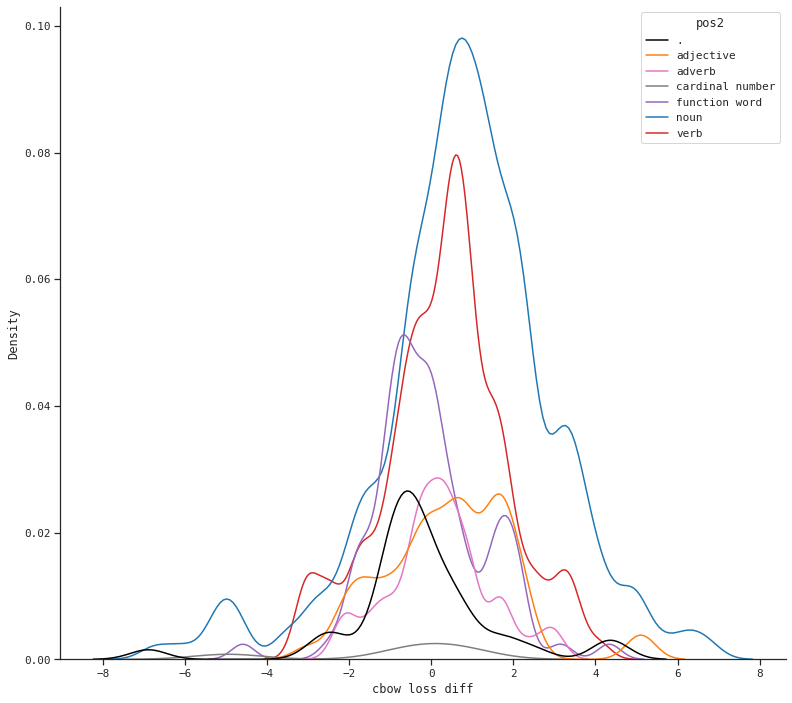

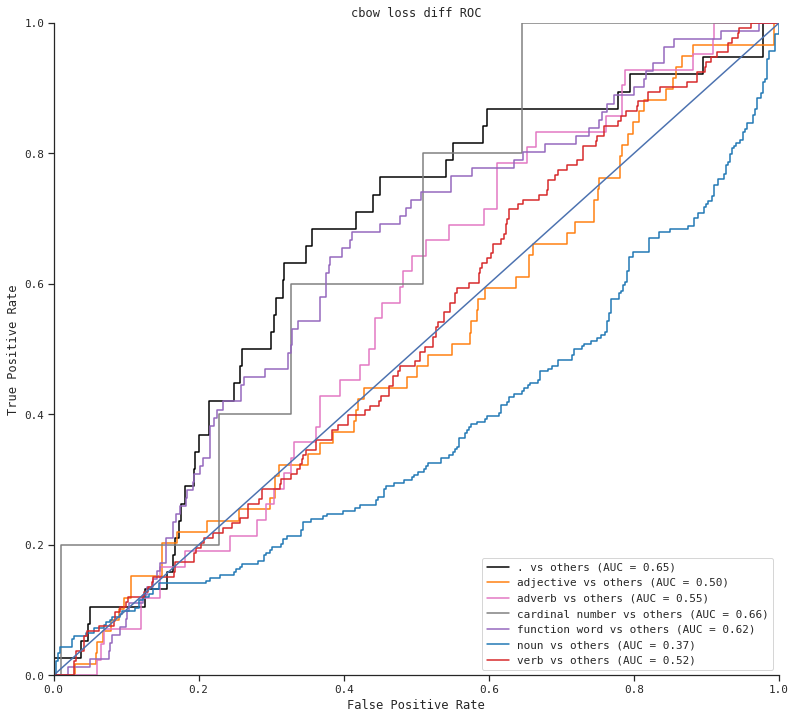

.               t-test result: statistic: -0.87 pvalue: 0.193747
adjective       t-test result: statistic:  2.16 pvalue: 0.982436
adverb          t-test result: statistic:  1.07 pvalue: 0.855267
cardinal number t-test result: statistic: -0.86 pvalue: 0.219235
function word   t-test result: statistic: -0.34 pvalue: 0.368336
noun            t-test result: statistic:  6.10 pvalue: 1.000000
verb            t-test result: statistic:  2.58 pvalue: 0.994568
all tokens      t-test result: statistic:  5.88 pvalue: 1.000000
n_label_0: 234, n_label_1: 358, best_accuracy: 62.84%
best_split_accuracy: 62.84%
plotting 592/592 = 100.00% items...


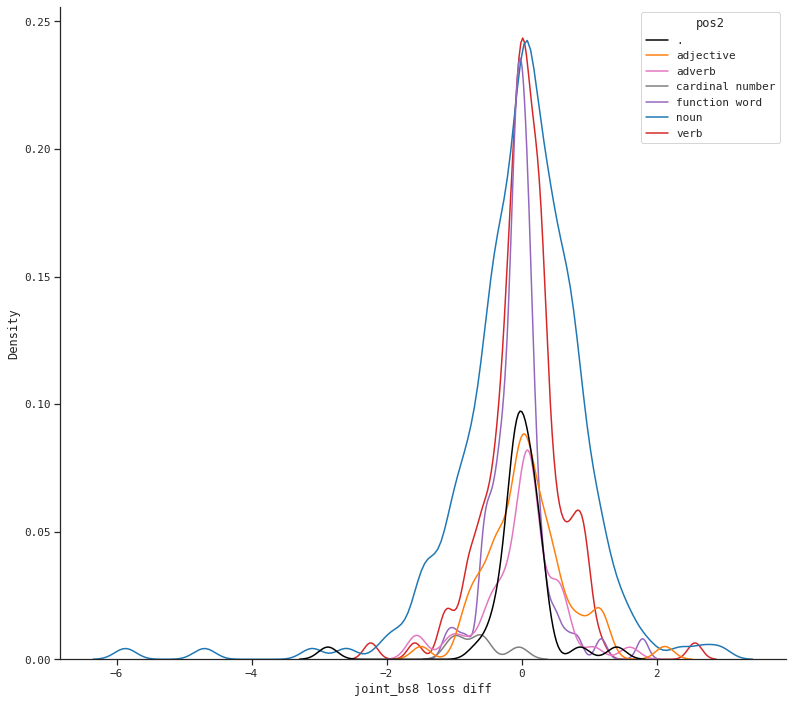

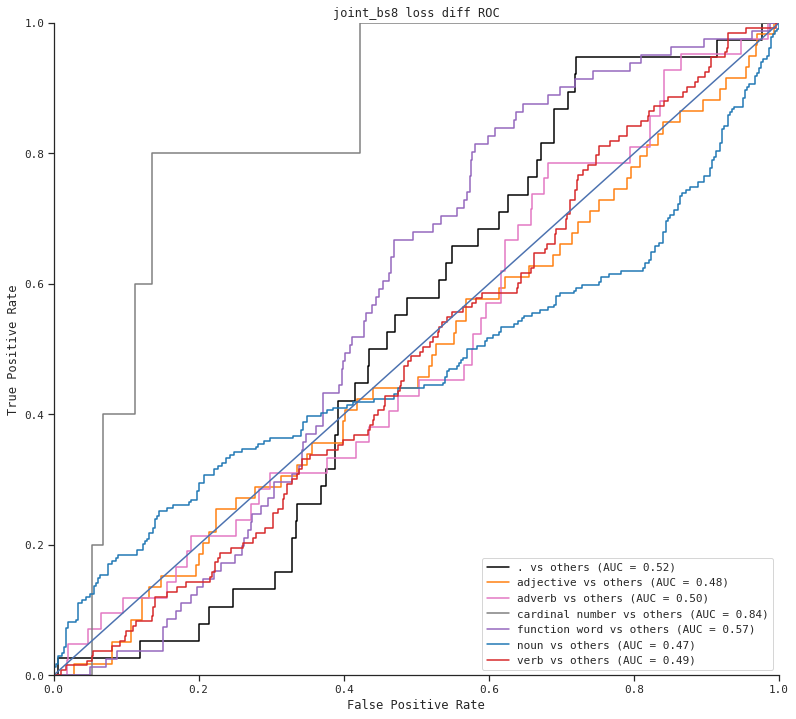

.               t-test result: statistic: -0.36 pvalue: 0.361722
adjective       t-test result: statistic:  1.04 pvalue: 0.847632
adverb          t-test result: statistic: -0.15 pvalue: 0.442543
cardinal number t-test result: statistic: -3.69 pvalue: 0.010526
function word   t-test result: statistic: -1.03 pvalue: 0.153016
noun            t-test result: statistic:  0.07 pvalue: 0.528005
verb            t-test result: statistic:  0.68 pvalue: 0.749932
all tokens      t-test result: statistic:  0.08 pvalue: 0.531335


In [16]:
from scipy.stats import ttest_rel


def get_best_split_accuracy(label_0, label_1):
    n_label_0 = label_0.value_counts()[True]
    n_label_1 = label_1.value_counts()[True]

    i = 0
    count_0 = 0
    count_1 = n_label_1

    best_i, best_n = i, count_0 + count_1

    for label_i_0, label_i_1 in zip(label_0, label_1):
        count_0 += label_i_0
        count_1 -= label_i_1
        i += 1

        if count_0 + count_1 > best_n:
            best_i, best_n = i, count_0 + count_1

    print(f'n_label_0: {n_label_0}, n_label_1: {n_label_1}, best_accuracy: {best_n / (n_label_0 + n_label_1):.2%}')
    return best_i, best_n / (n_label_0 + n_label_1)


def plot_ROC(y_true, y_score, pos_label=None, label="", **kwargs):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        label=f"{label} (AUC = {roc_auc:0.2f})",
        **kwargs,
    )


def plot_ROC_end(title="", **kwargs):
    plt.plot([0, 1], [0, 1], **kwargs)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} ROC")
    plt.legend(loc="lower right")
    plt.show()


def ttest(a, label):
    result = ttest_rel(a, np.zeros_like(a), alternative='less')
    print(f'{label:15} t-test result: statistic: {result.statistic:5.2f} pvalue: {result.pvalue:8.6f}')


sns.set_theme(
    style="ticks",
    font='monospace',
    rc={
        'figure.figsize': figsize,
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

pos_field = "pos2"

loss_diff_items = top_token_items
loss_diff_items = loss_diff_items[loss_diff_items['cnt'] >= 2]
for pos in loss_diff_items.dtypes[pos_field].categories:
    items = loss_diff_items[loss_diff_items[pos_field] == pos]
    if len(items) > 0:
        print(f'number of {pos}s: {len(items)}')
loss_diff_items_long = loss_diff_items.melt(id_vars=[pos_field], value_vars=[f'{name} loss diff' for name in names[1:] if 'contrastive' not in name], var_name='model', value_name='loss diff')
loss_diff_items_long['model'] = loss_diff_items_long['model'].map(lambda s: s[:-len(' loss diff')])
plot(sns.catplot, loss_diff_items_long, x='model', y='loss diff', hue=pos_field, hlines=[0], kind="box", figsize=(26, 12), medianprops=dict(color="white", alpha=0.7), title="loss - lm loss difference")

for name in filter(lambda name: 'contrastive' not in name, names[1:]):
    loss_diff_field = f"{name} loss diff"
    items = loss_diff_items.sort_values(loss_diff_field)
    label_0 = items[pos_field].isin(["noun"])
    label_1 = ~label_0 #items[pos_field].isin(["function word", "adjective", "adverb", "cardinal number"])
    if True:
        best_split_i, best_split_acc = get_best_split_accuracy(label_0, label_1)
        print(f'best_split_accuracy: {best_split_acc:.2%}')
        threshold = items.iloc[min(best_split_i, len(items)-1)][loss_diff_field]

    plot(sns.kdeplot, items, x=loss_diff_field, hue=pos_field, bw_adjust=.5)

    for pos in items.dtypes[pos_field].categories:
        plot_ROC(items[pos_field], -items[loss_diff_field], pos_label=pos, label=f"{pos} vs others", color=pos_palette[pos])
    plot_ROC_end(title=loss_diff_field)

    for pos in items.dtypes[pos_field].categories:
        ttest(items.loc[items[pos_field] == pos, loss_diff_field], pos)
    ttest(items[loss_diff_field], "all tokens")

capt:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
all:
plotting 125/1308 = 9.56% items...


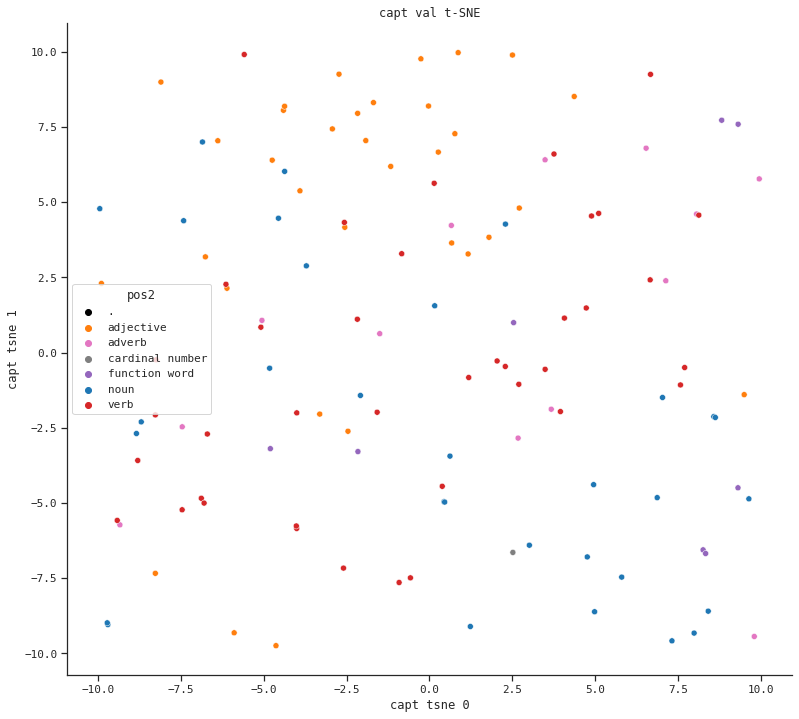

plotting 1308/1308 = 100.00% items...


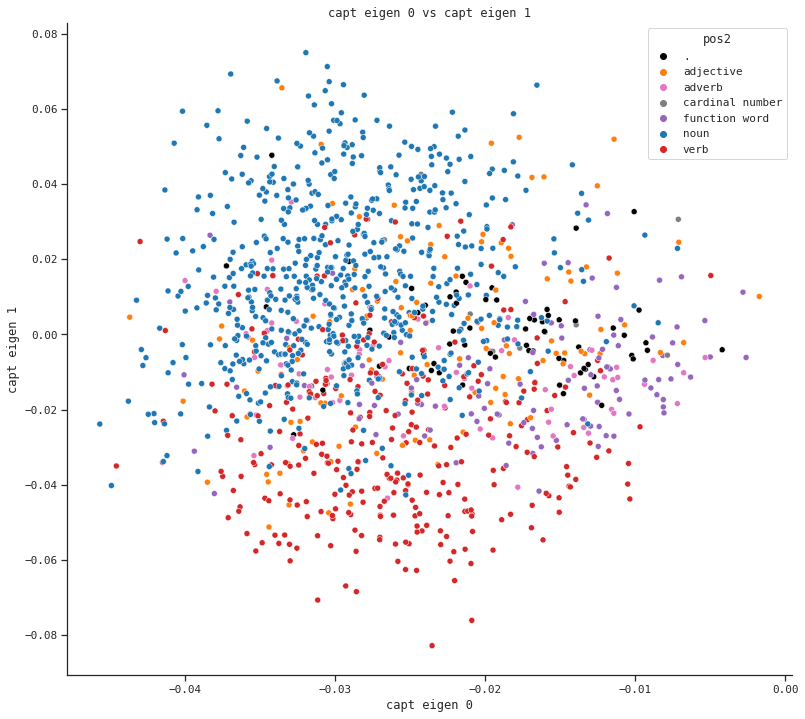

plotting 125/1308 = 9.56% items...


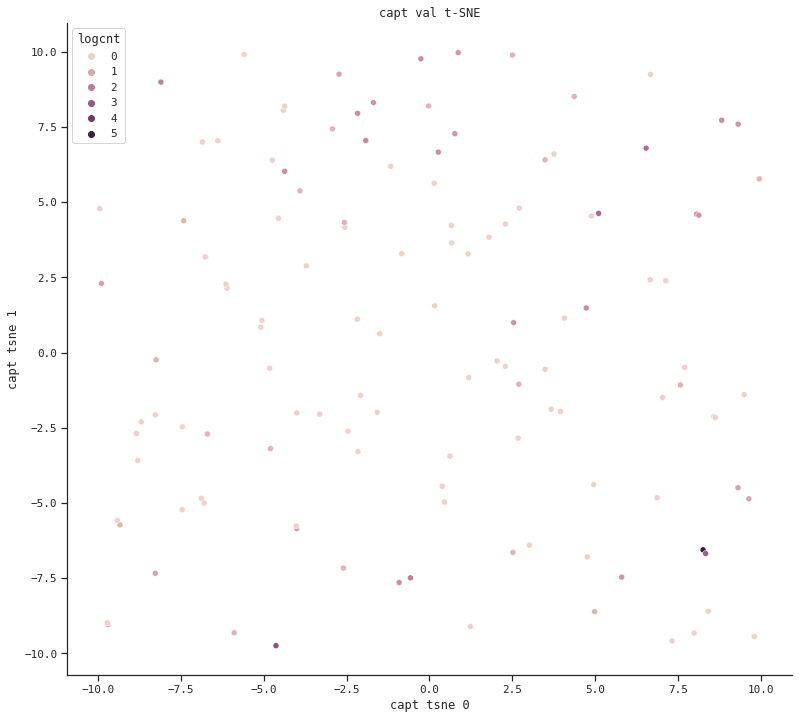

plotting 1308/1308 = 100.00% items...


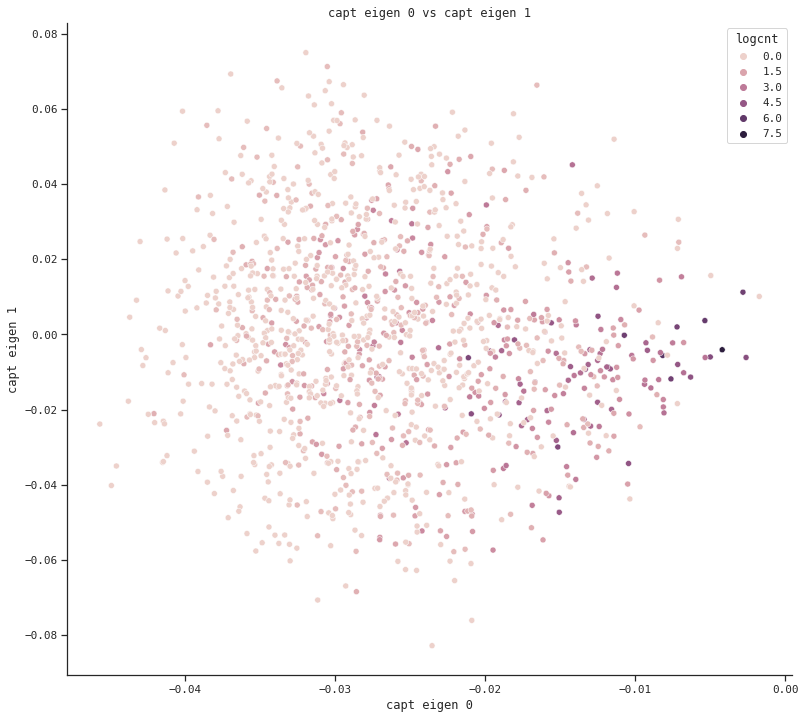

plotting 110/1308 = 8.41% items...


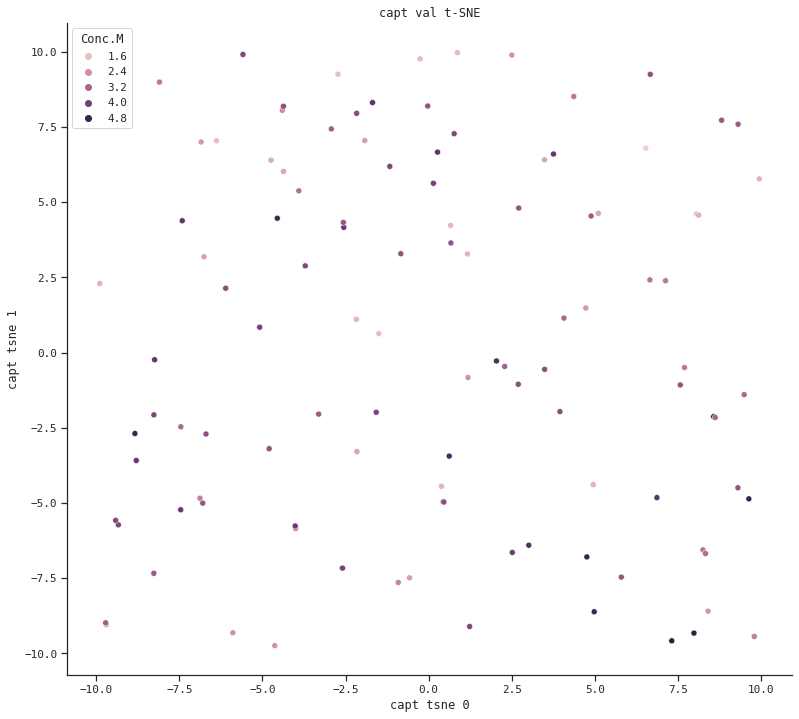

plotting 1072/1308 = 81.96% items...


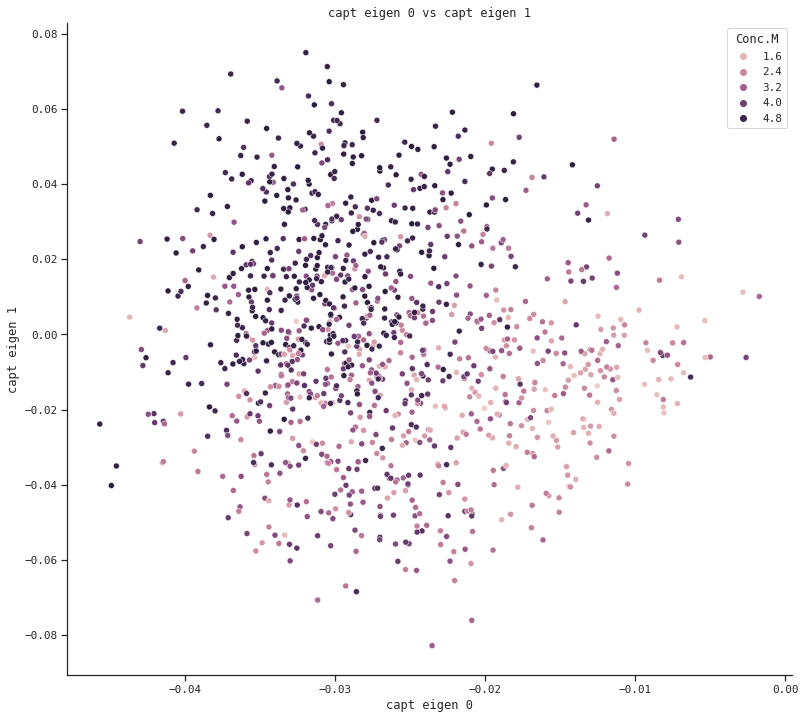

plotting 1072/1308 = 81.96% items...


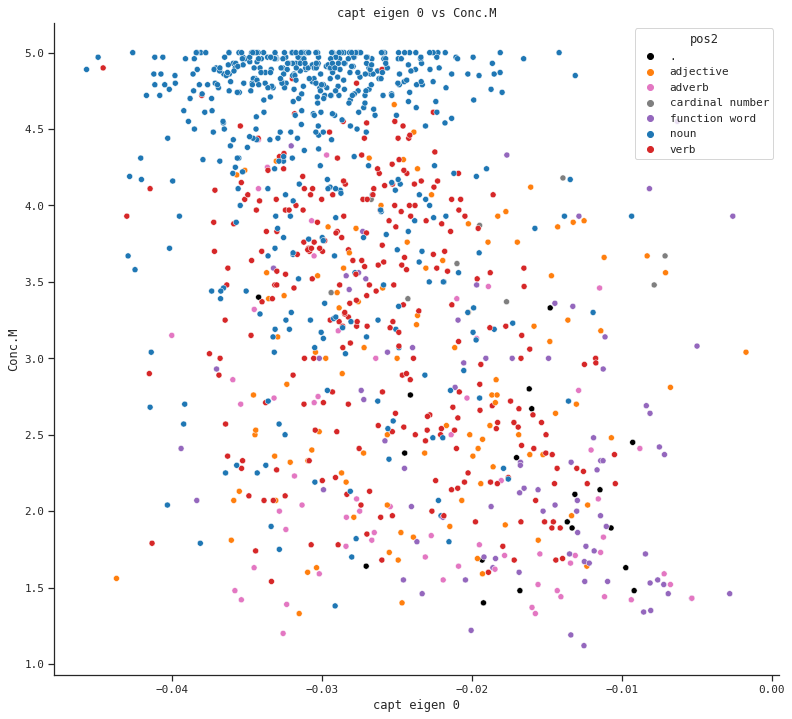

plotting 1072/1308 = 81.96% items...


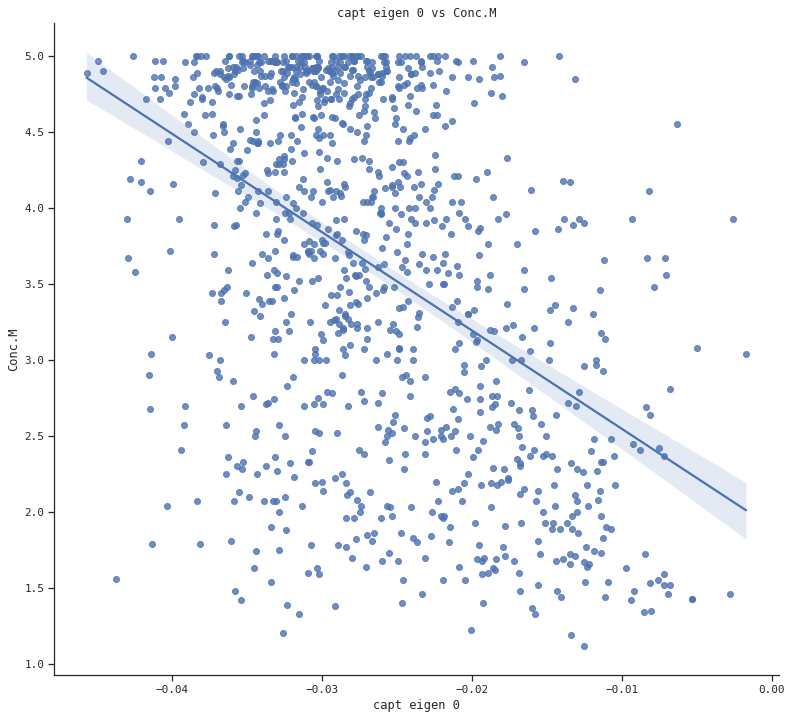

plotting 1072/1308 = 81.96% items...


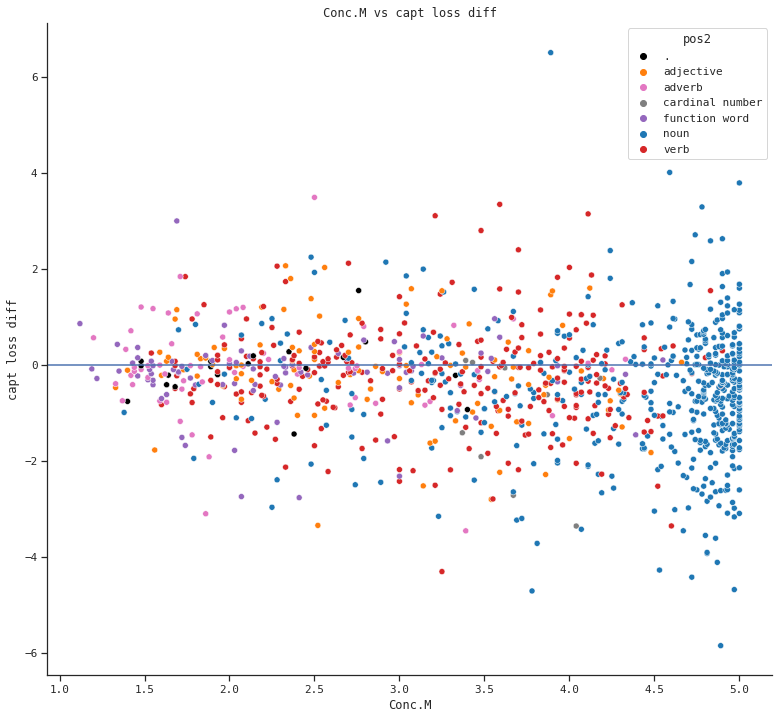

plotting 1072/1308 = 81.96% items...


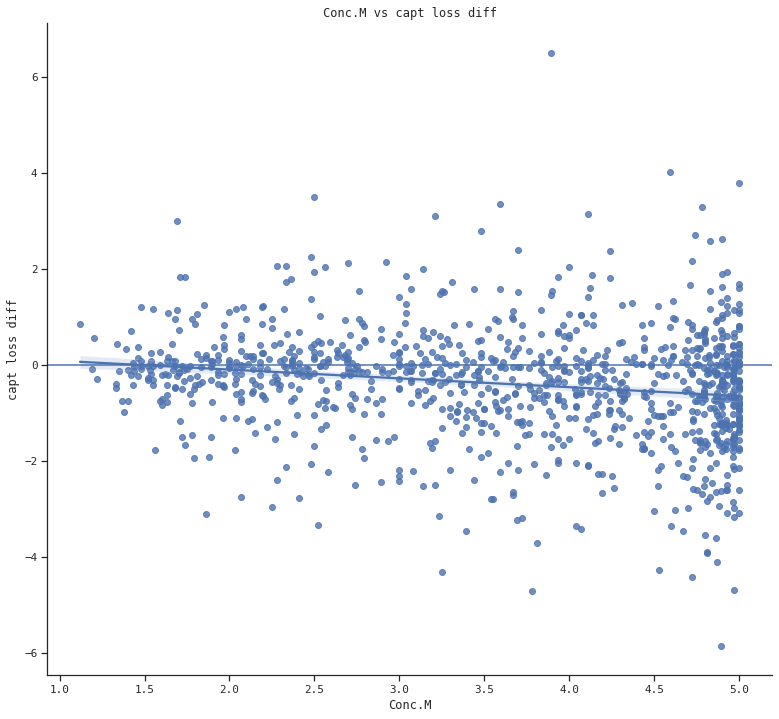

top:
plotting 125/1308 = 9.56% items...


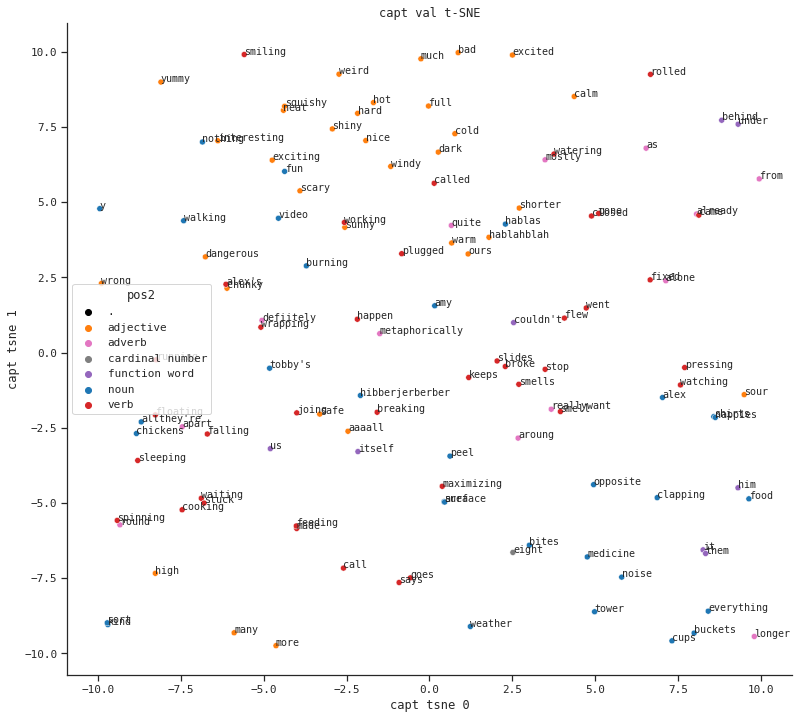

plotting 175/1308 = 13.38% items...


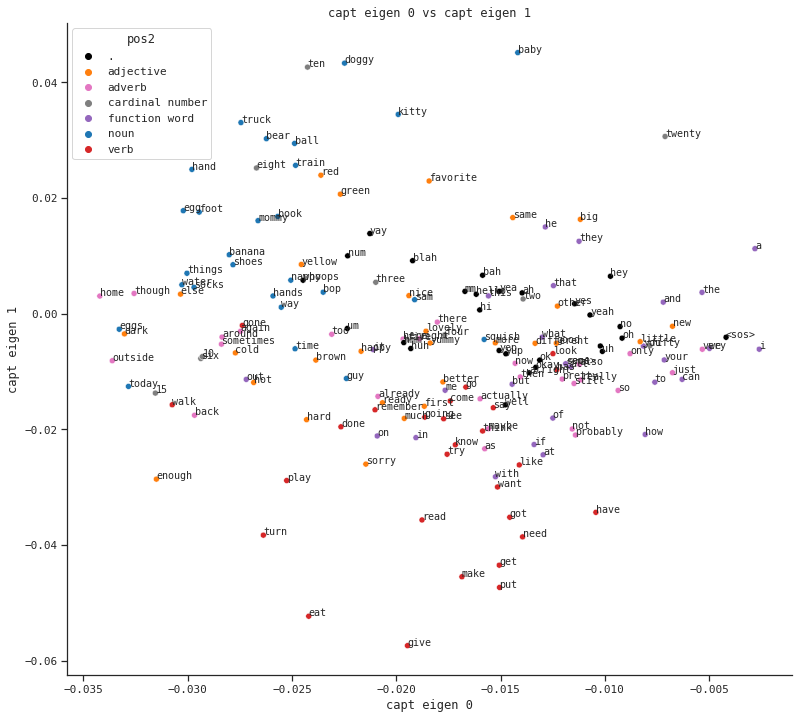

plotting 125/1308 = 9.56% items...


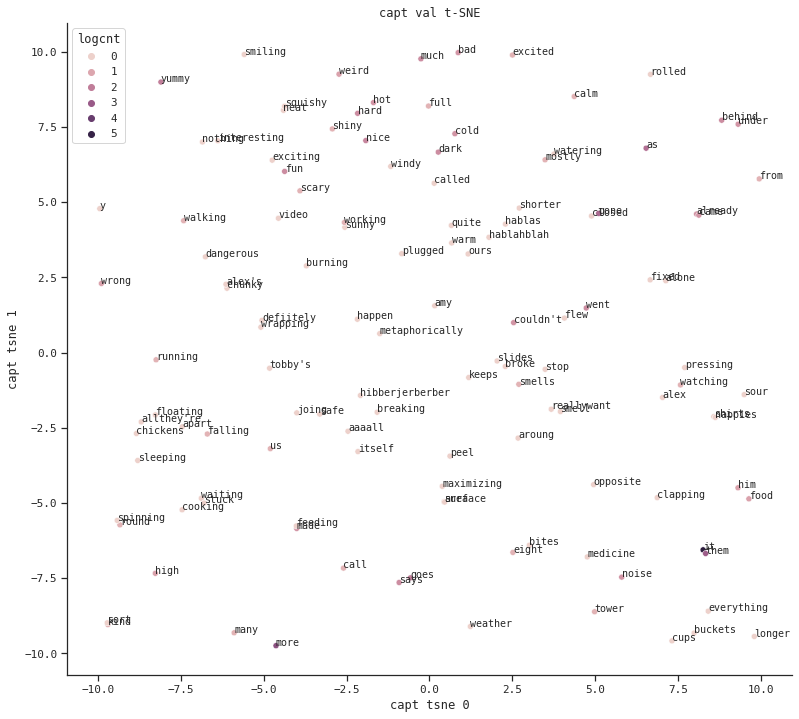

plotting 175/1308 = 13.38% items...


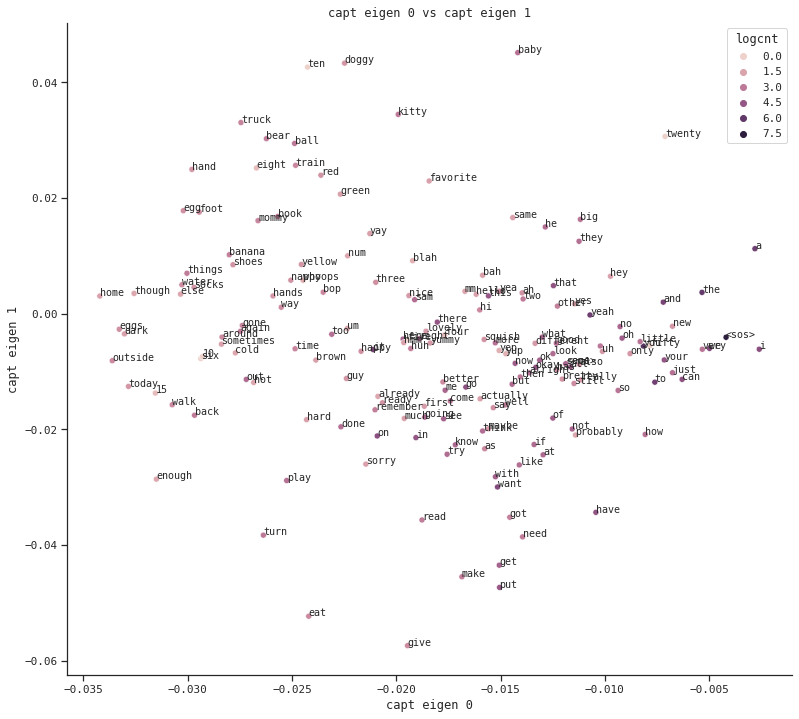

plotting 110/1308 = 8.41% items...


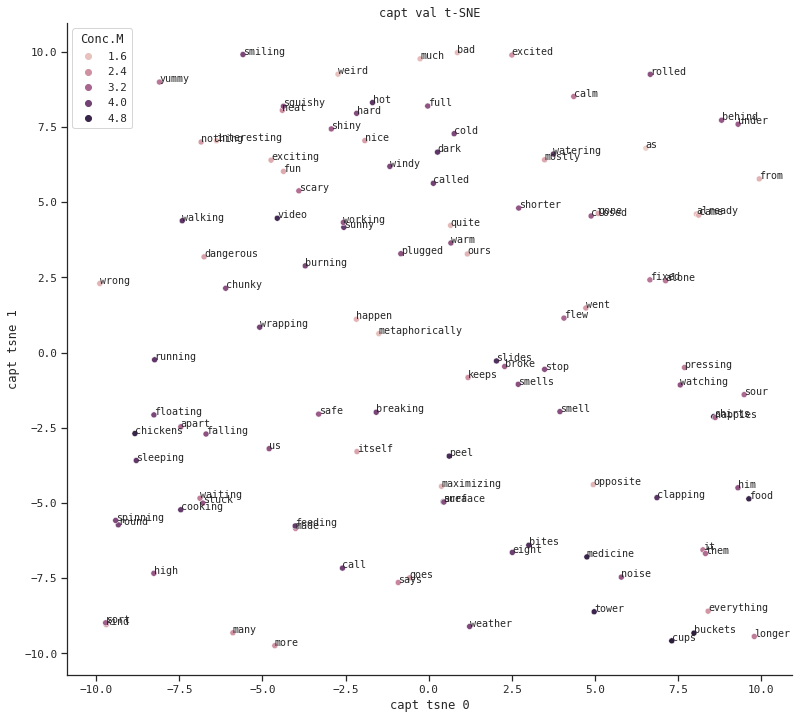

plotting 175/1308 = 13.38% items...


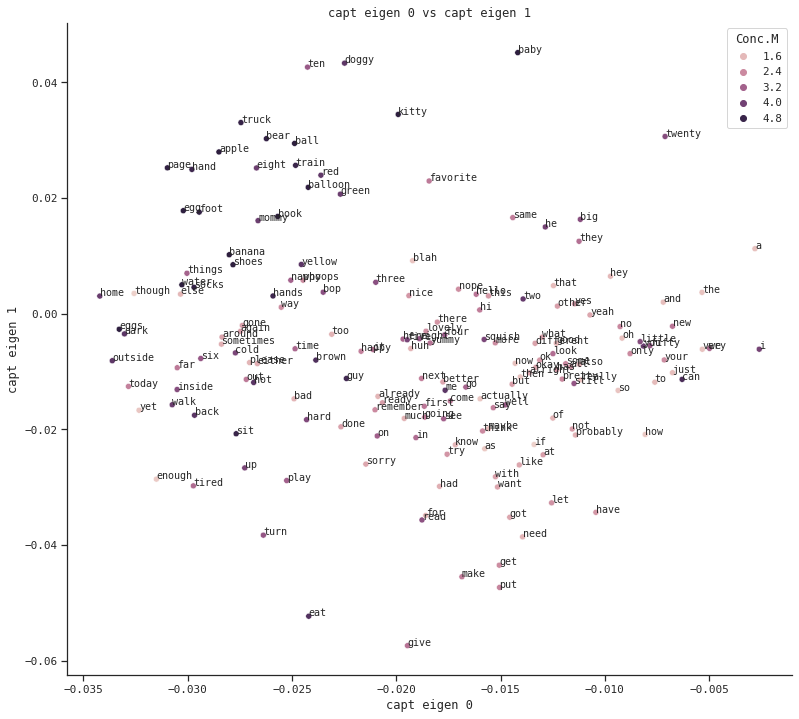

plotting 175/1308 = 13.38% items...


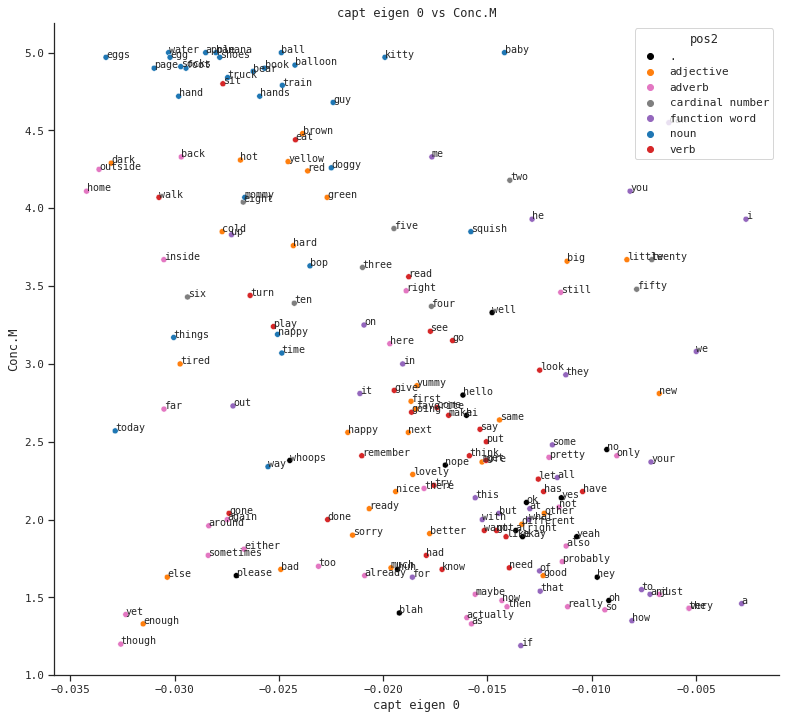

plotting 175/1308 = 13.38% items...


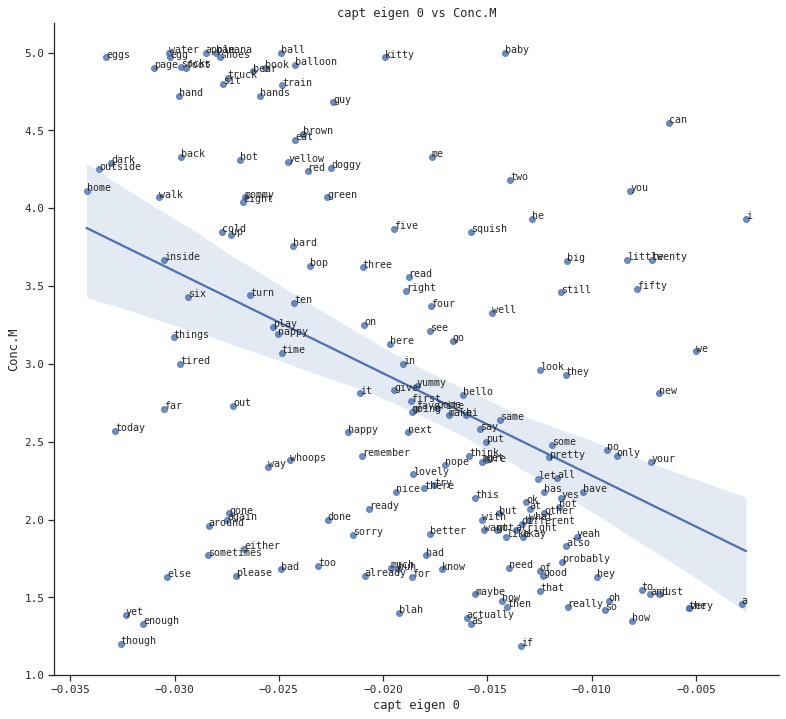

plotting 233/248 = 93.95% items...


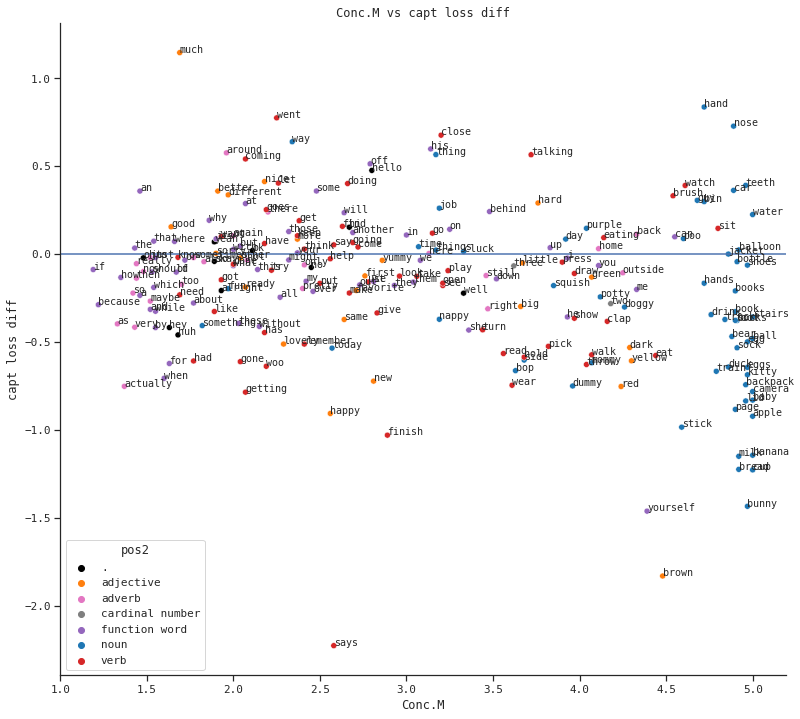

In [17]:
pos_field = "pos2"

conc_dim = {
    "val": "eigen 0",
    "test": "eigen 0",
}

noun_verb_dim = {
    "train": "eigen 2",
    "val": "eigen 1",
    "test": "eigen 1",
}

for n, name in enumerate(names):
    if name != 'capt':
        continue

    print(f'{name}:')
    fields = [pos_field, "cnt", "logcnt", conc_field, "AnimPhysical", "AnimMental", "Category", "AoA", f'{name} loss', f'{name} loss diff']

    get_tsne_points(token_items[name], get_attr=vector_attr, perplexity=30, learning_rate=10)
    extend_point_items(token_items, name, 'tsne')

    for items_name, items, n_items in (
        ("all", pos__items, None),
        ("top", pos__items, len(used_poses) * interleaving_step * (25 // interleaving_step)),
        #('noun_verb', pos_pos_items[('noun', 'verb')], None),
        #('noun_verb', pos_pos_items[('noun', 'verb')], 2 * interleaving_step * (25 // interleaving_step)),
    ):
        print(f'{items_name}:')
        token_kwargs = {'fontsize': 'small'} if n_items is not None else None
        for hue in fields[:1] + fields[2:3] + fields[3:4]:
            plot(sns.scatterplot, items, x=f"{name} tsne 0", y=f"{name} tsne 1", hue=hue, n_items=n_items, token_kwargs=token_kwargs, title=f"{name} {split} t-SNE", xrange=[-10, 10], yrange=[-10, 10])
            if split in conc_dim:
                plot(sns.scatterplot, items, x=f"{name} {conc_dim[split]}", y=f"{name} {noun_verb_dim[split]}", hue=hue, n_items=n_items, token_kwargs=token_kwargs, title="vs")
            else:
                for eigen_i in range(3):
                    if f'eigen {eigen_i}' != noun_verb_dim[split]:
                        plot(sns.scatterplot, items, x=f"{name} eigen {eigen_i}", y=f"{name} {noun_verb_dim[split]}", hue=hue, n_items=n_items, token_kwargs=token_kwargs, title="vs")
        if split in conc_dim:
            plot(sns.scatterplot, items, x=f"{name} {conc_dim[split]}", y=conc_field, hue=pos_field, n_items=n_items, token_kwargs=token_kwargs, title="vs")
            plot(sns.regplot, items, x=f"{name} {conc_dim[split]}", y=conc_field, n_items=n_items, token_kwargs=token_kwargs, title="vs")
        if n != 0:
            loss_diff_items = items.sort_values(f'{name} loss diff')
            if n_items is not None:
                loss_diff_items = loss_diff_items[loss_diff_items['cnt'] >= 5]
                if n_items * 2 >= len(loss_diff_items):
                    n_items = len(loss_diff_items)
            plot(sns.scatterplot, loss_diff_items, x=conc_field, y=fields[-1], hue=pos_field, n_items=n_items, hlines=[0], token_kwargs=token_kwargs, title="vs")
            if n_items is None:
                plot(sns.regplot, loss_diff_items, x=conc_field, y=fields[-1], n_items=n_items, hlines=[0], token_kwargs=token_kwargs, title="vs")
                #plot(sns.catplot, loss_diff_items, x=pos_field, y=fields[-1], n_items=n_items, color="b", hlines=[0], title="vs") #kind="violin", inner="stick",
            if n_items is not None and n_items < len(loss_diff_items):
                plot(sns.scatterplot, loss_diff_items[::-1], x=conc_field, y=fields[-1], hue=pos_field, n_items=n_items, hlines=[0], token_kwargs=token_kwargs, title="vs")